In [1]:
import os
import sys

import pandas as pd
import numpy as np
import math

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import missingno as msno
import seaborn as sns
import statsmodels.api as sm
import warnings

from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
os.chdir(r"C:\dengueredo")

#Load given dataframes with year, weekofyear, and city as indexes
train_features = pd.read_csv('dengue_features_train.csv', index_col=[0,1,2])
train_labels = pd.read_csv('dengue_labels_train.csv', index_col=[0,1,2])
test_features = pd.read_csv('dengue_features_test.csv', index_col=[0,1,2])

In [4]:
#Visualize all data without city separation
train_features

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city year weekofyear                                                           
sj   1990 18              1990-04-30  0.122600  0.103725  0.198483  0.177617   
          19              1990-05-07  0.169900  0.142175  0.162357  0.155486   
          20              1990-05-14  0.032250  0.172967  0.157200  0.170843   
          21              1990-05-21  0.128633  0.245067  0.227557  0.235886   
          22              1990-05-28  0.196200  0.262200  0.251200  0.247340   
...                              ...       ...       ...       ...       ...   
iq   2010 21              2010-05-28  0.342750  0.318900  0.256343  0.292514   
          22              2010-06-04  0.160157  0.160371  0.136043  0.225657   
          23              2010-06-11  0.247057  0.146057  0.250357  0.233714   
          24              2010-06-18  0.333914  0.245771  0.278886  0.325486   
          25              2010-06-25  0.298186  0.232971  0.274214  0.315757   

                      precipitation_amt_mm  reanalysis_air_temp_k  \
city year weekofyear                                                
sj   1990 18                         12.42             297.572857   
          19                         22.82             298.211429   
          20                         34.54             298.781429   
          21                         15.36             298.987143   
          22                          7.52             299.518571   
...                                    ...                    ...   
iq   2010 21                         55.30             299.334286   
          22                         86.47             298.330000   
          23                         58.94             296.598571   
          24                         59.67             296.345714   
          25                         63.22             298.097143   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
city year weekofyear                                                       
sj   1990 18                     297.742857                   292.414286   
          19                     298.442857                   293.951429   
          20                     298.878571                   295.434286   
          21                     299.228571                   295.310000   
          22                     299.664286                   295.821429   
...                                     ...                          ...   
iq   2010 21                     300.771429                   296.825714   
          22                     299.392857                   296.452857   
          23                     297.592857                   295.501429   
          24                     297.521429                   295.324286   
          25                     299.835714                   295.807143   

                      reanalysis_max_air_temp_k  ...  \
city year weekofyear                             ...   
sj   1990 18                              299.8  ...   
          19                              300.9  ...   
          20                              300.5  ...   
          21                              301.4  ...   
          22                              301.9  ...   
...                                         ...  ...   
iq   2010 21                              309.7  ...   
          22                              308.5  ...   
          23                              305.5  ...   
          24                              306.1  ...   
          25                              307.8  ...   

                      reanalysis_relative_humidity_percent  \
city year weekofyear                                         
sj   1990 18                                     73.365714   
          19                                     77.368571   
          20                                     82.052857   
          21                                     80.33

In [5]:
test_features

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city year weekofyear                                                           
sj   2008 18              2008-04-29 -0.018900 -0.018900  0.102729  0.091200   
          19              2008-05-06 -0.018000 -0.012400  0.082043  0.072314   
          20              2008-05-13 -0.001500       NaN  0.151083  0.091529   
          21              2008-05-20       NaN -0.019867  0.124329  0.125686   
          22              2008-05-27  0.056800  0.039833  0.062267  0.075914   
...                              ...       ...       ...       ...       ...   
iq   2013 22              2013-05-28  0.301471  0.380029  0.280629  0.383186   
          23              2013-06-04  0.247600  0.296343  0.285371  0.350357   
          24              2013-06-11  0.238729  0.251029  0.252586  0.249771   
          25              2013-06-18  0.310429  0.302700  0.406614  0.403943   
          26              2013-06-25  0.339467  0.240071  0.356943  0.273600   

                      precipitation_amt_mm  reanalysis_air_temp_k  \
city year weekofyear                                                
sj   2008 18                         78.60             298.492857   
          19                         12.56             298.475714   
          20                          3.66             299.455714   
          21                          0.00             299.690000   
          22                          0.76             299.780000   
...                                    ...                    ...   
iq   2013 22                         41.12             297.774286   
          23                         71.52             297.167143   
          24                         78.96             295.831429   
          25                         39.54             295.778571   
          26                         51.80             297.372857   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
city year weekofyear                                                       
sj   2008 18                     298.550000                   294.527143   
          19                     298.557143                   294.395714   
          20                     299.357143                   295.308571   
          21                     299.728571                   294.402857   
          22                     299.671429                   294.760000   
...                                     ...                          ...   
iq   2013 22                     298.964286                   295.638571   
          23                     298.328571                   295.845714   
          24                     296.607143                   294.894286   
          25                     297.400000                   293.648571   
          26                     299.000000                   294.615714   

                      reanalysis_max_air_temp_k  ...  \
city year weekofyear                             ...   
sj   2008 18                              301.1  ...   
          19                              300.8  ...   
          20                              302.2  ...   
          21                              303.0  ...   
          22                              302.3  ...   
...                                         ...  ...   
iq   2013 22                              305.5  ...   
          23                              306.3  ...   
          24                              304.6  ...   
          25                              305.9  ...   
          26                              307.3  ...   

                      reanalysis_relative_humidity_percent  \
city year weekofyear                                         
sj   2008 18                                     78.781429   
          19                                     78.230000   
          20                                     78.270000   
          21                                     73.01

In [3]:
#Function to convert weekofyear to season based on the assumption there are 13 weeks per season
def week_to_season(week):
    if 1 <= week <= 13:
        return 1  #Winter
    elif 14 <= week <= 26:
        return 2  #Spring
    elif 27 <= week <= 39:
        return 3  #Summer
    elif 40 <= week <= 53:
        return 4  #Fall

#Determine if 'weekofyear' is a level in the MultiIndex and apply the function to that level
if 'weekofyear' in train_features.index.names:
    weekofyear_index = train_features.index.names.index('weekofyear')
    train_features['season'] = train_features.index.get_level_values(weekofyear_index).map(week_to_season)

if 'weekofyear' in test_features.index.names:
    weekofyear_index = test_features.index.names.index('weekofyear')
    test_features['season'] = test_features.index.get_level_values(weekofyear_index).map(week_to_season)

                     week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
city year weekofyear                                                           
sj   1990 18              1990-04-30  0.122600  0.103725  0.198483  0.177617   
          19              1990-05-07  0.169900  0.142175  0.162357  0.155486   
          20              1990-05-14  0.032250  0.172967  0.157200  0.170843   
          21              1990-05-21  0.128633  0.245067  0.227557  0.235886   
          22              1990-05-28  0.196200  0.262200  0.251200  0.247340   

                      precipitation_amt_mm  reanalysis_air_temp_k  \
city year weekofyear                                                
sj   1990 18                         12.42             297.572857   
          19                         22.82             298.211429   
          20                         34.54             298.781429   
          21                         15.36             298.987143   
          22             

In [7]:
#Separate given data by city
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

sj_test_features = test_features.loc['sj']
iq_test_features = test_features.loc['iq']

In [8]:
#Visualize San Juan data
sj_train_features

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
1990 18              1990-04-30  0.122600  0.103725  0.198483  0.177617   
     19              1990-05-07  0.169900  0.142175  0.162357  0.155486   
     20              1990-05-14  0.032250  0.172967  0.157200  0.170843   
     21              1990-05-21  0.128633  0.245067  0.227557  0.235886   
     22              1990-05-28  0.196200  0.262200  0.251200  0.247340   
...                         ...       ...       ...       ...       ...   
2008 13              2008-03-25  0.077850 -0.039900  0.310471  0.296243   
     14              2008-04-01 -0.038000 -0.016833  0.119371  0.066386   
     15              2008-04-08 -0.155200 -0.052750  0.137757  0.141214   
     16              2008-04-15  0.001800       NaN  0.203900  0.209843   
     17              2008-04-22 -0.037000 -0.010367  0.077314  0.090586   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
1990 18                         12.42             297.572857   
     19                         22.82             298.211429   
     20                         34.54             298.781429   
     21                         15.36             298.987143   
     22                          7.52             299.518571   
...                               ...                    ...   
2008 13                         27.19             296.958571   
     14                          3.82             298.081429   
     15                         16.96             297.460000   
     16                          0.00             297.630000   
     17                          0.00             298.672857   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
1990 18                     297.742857                   292.414286   
     19                     298.442857                   293.951429   
     20                     298.878571                   295.434286   
     21                     299.228571                   295.310000   
     22                     299.664286                   295.821429   
...                                ...                          ...   
2008 13                     296.957143                   292.095714   
     14                     298.228571                   293.235714   
     15                     297.564286                   292.732857   
     16                     297.778571                   292.274286   
     17                     298.692857                   294.280000   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
1990 18                              299.8  ...   
     19                              300.9  ...   
     20                              300.5  ...   
     21                              301.4  ...   
     22                              301.9  ...   
...                                    ...  ...   
2008 13                              299.7  ...   
     14                              299.8  ...   
     15                              299.4  ...   
     16                              299.7  ...   
     17                              300.9  ...   

                 reanalysis_relative_humidity_percent  \
year weekofyear                                         
1990 18                                     73.365714   
     19                                     77.368571   
     20                                     82.052857   
     21                                     80.337143   
     22                                     80.460000   
...                                               ...   
2008 13                                     74.247143   
     14                                     74.600000   
     15                                     75.02

In [10]:
#Visualize Iquitos data
iq_train_features

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
2000 26              2000-07-01  0.192886  0.132257  0.340886  0.247200   
     27              2000-07-08  0.216833  0.276100  0.289457  0.241657   
     28              2000-07-15  0.176757  0.173129  0.204114  0.128014   
     29              2000-07-22  0.227729  0.145429  0.254200  0.200314   
     30              2000-07-29  0.328643  0.322129  0.254371  0.361043   
...                         ...       ...       ...       ...       ...   
2010 21              2010-05-28  0.342750  0.318900  0.256343  0.292514   
     22              2010-06-04  0.160157  0.160371  0.136043  0.225657   
     23              2010-06-11  0.247057  0.146057  0.250357  0.233714   
     24              2010-06-18  0.333914  0.245771  0.278886  0.325486   
     25              2010-06-25  0.298186  0.232971  0.274214  0.315757   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
2000 26                         25.41             296.740000   
     27                         60.61             296.634286   
     28                         55.52             296.415714   
     29                          5.60             295.357143   
     30                         62.76             296.432857   
...                               ...                    ...   
2010 21                         55.30             299.334286   
     22                         86.47             298.330000   
     23                         58.94             296.598571   
     24                         59.67             296.345714   
     25                         63.22             298.097143   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
2000 26                     298.450000                   295.184286   
     27                     298.428571                   295.358571   
     28                     297.392857                   295.622857   
     29                     296.228571                   292.797143   
     30                     297.635714                   293.957143   
...                                ...                          ...   
2010 21                     300.771429                   296.825714   
     22                     299.392857                   296.452857   
     23                     297.592857                   295.501429   
     24                     297.521429                   295.324286   
     25                     299.835714                   295.807143   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
2000 26                              307.3  ...   
     27                              306.6  ...   
     28                              304.5  ...   
     29                              303.6  ...   
     30                              307.0  ...   
...                                    ...  ...   
2010 21                              309.7  ...   
     22                              308.5  ...   
     23                              305.5  ...   
     24                              306.1  ...   
     25                              307.8  ...   

                 reanalysis_relative_humidity_percent  \
year weekofyear                                         
2000 26                                     92.418571   
     27                                     93.581429   
     28                                     95.848571   
     29                                     87.234286   
     30                                     88.161429   
...                                               ...   
2010 21                                     88.765714   
     22                                     91.600000   
     23                                     94.28

In [11]:
#Takes training features and labels as input, outputs the processed training features
def train_data_preprocessor(train_features, train_labels):
    #Merge features with labels (total cases), keeping features
    train_features = train_features.merge(train_labels, on = ['year', 'weekofyear'], how = 'left')

    #Adding month as a feature
    train_features['week_start_date'] = pd.to_datetime(train_features['week_start_date'])
    train_features['month'] = train_features['week_start_date'].dt.month
    
    #Convert from Kelvin to Celsius
    for column in ['reanalysis_max_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_air_temp_k', 
                   'reanalysis_min_air_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_tdtr_k']:
        train_features[column] -= 273.15
        
    return train_features

sj_train_data = train_data_preprocessor(sj_train_features, sj_train_labels)
iq_train_data = train_data_preprocessor(iq_train_features, iq_train_labels)

In [12]:
#Overview of San Juan data
sj_train_data

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
1990 18              1990-04-30  0.122600  0.103725  0.198483  0.177617   
     19              1990-05-07  0.169900  0.142175  0.162357  0.155486   
     20              1990-05-14  0.032250  0.172967  0.157200  0.170843   
     21              1990-05-21  0.128633  0.245067  0.227557  0.235886   
     22              1990-05-28  0.196200  0.262200  0.251200  0.247340   
...                         ...       ...       ...       ...       ...   
2008 13              2008-03-25  0.077850 -0.039900  0.310471  0.296243   
     14              2008-04-01 -0.038000 -0.016833  0.119371  0.066386   
     15              2008-04-08 -0.155200 -0.052750  0.137757  0.141214   
     16              2008-04-15  0.001800       NaN  0.203900  0.209843   
     17              2008-04-22 -0.037000 -0.010367  0.077314  0.090586   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
1990 18                         12.42              24.422857   
     19                         22.82              25.061429   
     20                         34.54              25.631429   
     21                         15.36              25.837143   
     22                          7.52              26.368571   
...                               ...                    ...   
2008 13                         27.19              23.808571   
     14                          3.82              24.931429   
     15                         16.96              24.310000   
     16                          0.00              24.480000   
     17                          0.00              25.522857   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
1990 18                      24.592857                    19.264286   
     19                      25.292857                    20.801429   
     20                      25.728571                    22.284286   
     21                      26.078571                    22.160000   
     22                      26.514286                    22.671429   
...                                ...                          ...   
2008 13                      23.807143                    18.945714   
     14                      25.078571                    20.085714   
     15                      24.414286                    19.582857   
     16                      24.628571                    19.124286   
     17                      25.542857                    21.130000   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
1990 18                              26.65  ...   
     19                              27.75  ...   
     20                              27.35  ...   
     21                              28.25  ...   
     22                              28.75  ...   
...                                    ...  ...   
2008 13                              26.55  ...   
     14                              26.65  ...   
     15                              26.25  ...   
     16                              26.55  ...   
     17                              27.75  ...   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
year weekofyear                                                             
1990 18                                      14.012857        -270.521429   
     19                                      15.372857        -270.778571   
     20                                      16.848571        -270.850000   
     21                                      16.672857        -270.721429   
     22                                      17.210000        -270.135714   
...                                                ...                ...   
200

In [13]:
#Summary statistics for San Juan
sj_train_data.describe()

ndvi_ne     ndvi_nw     ndvi_se     ndvi_sw  precipitation_amt_mm  \
count  745.000000  887.000000  917.000000  917.000000            927.000000   
mean     0.057925    0.067469    0.177655    0.165956             35.470809   
std      0.107153    0.092479    0.057166    0.056073             44.606137   
min     -0.406250   -0.456100   -0.015533   -0.063457              0.000000   
25%      0.004500    0.016425    0.139283    0.129157              0.000000   
50%      0.057700    0.068075    0.177186    0.165971             20.800000   
75%      0.111100    0.115200    0.212557    0.202771             52.180000   
max      0.493400    0.437100    0.393129    0.381420            390.600000   

       reanalysis_air_temp_k  reanalysis_avg_temp_k  \
count             930.000000             930.000000   
mean               26.013653              26.126920   
std                 1.236429               1.218637   
min                22.788571              22.964286   
25%                25.045000              25.150000   
50%                26.104286              26.228571   
75%                26.982857              27.078571   
max                29.050000              29.014286   

       reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
count                   930.000000                 930.000000   
mean                     21.959519                  28.248817   
std                       1.569943                   1.258927   
min                      16.492857                  24.650000   
25%                      20.697857                  27.250000   
50%                      22.314286                  28.350000   
75%                      23.268929                  29.250000   
max                      24.645714                  31.150000   

       reanalysis_min_air_temp_k  ...  reanalysis_specific_humidity_g_per_kg  \
count                 930.000000  ...                             930.000000   
mean                   24.151828  ...                              16.552409   
std                     1.294705  ...                               1.560923   
min                    19.450000  ...                              11.715714   
25%                    23.150000  ...                              15.236429   
50%                    24.350000  ...                              16.845714   
75%                    25.250000  ...                              17.858571   
max                    26.750000  ...                              19.440000   

       reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
count         930.000000          930.000000               930.000000   
mean         -270.633733           27.006528                 6.757373   
std             0.498892            1.415473                 0.835993   
min          -271.792857           22.842857                 4.528571   
25%          -270.992857           25.842857                 6.200000   
50%          -270.692857           27.228571                 6.757143   
75%          -270.350000           28.185714                 7.285714   
max          -268.721429           30.071429                 9.914286   

       station_max_temp_c  station_min_temp_c  station_precip_mm      season  \
count          930.000000          930.000000         930.000000  936.000000   
mean            31.607957           22.600645          26.785484    2.500000   
std              1.717297            1.506277          29.325811    1.118632   
min             26.700000           17.800000           0.000000    1.000000   
25%             30.600000           21.700000           6.825000    1.750000   
50%             31.700000           22.800000          17.750000    2.500000   
75%             32.800000           23.900000          35.450000    3.250000   
max             35.600000           25.600000         305.900000    4.000000   

       total_cases       month  
count   936.000000  936.000000  
mean     34.180556    6.418803  
std      51.38137

In [14]:
#Overview of Iquitos data
iq_train_data

week_start_date   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
year weekofyear                                                           
2000 26              2000-07-01  0.192886  0.132257  0.340886  0.247200   
     27              2000-07-08  0.216833  0.276100  0.289457  0.241657   
     28              2000-07-15  0.176757  0.173129  0.204114  0.128014   
     29              2000-07-22  0.227729  0.145429  0.254200  0.200314   
     30              2000-07-29  0.328643  0.322129  0.254371  0.361043   
...                         ...       ...       ...       ...       ...   
2010 21              2010-05-28  0.342750  0.318900  0.256343  0.292514   
     22              2010-06-04  0.160157  0.160371  0.136043  0.225657   
     23              2010-06-11  0.247057  0.146057  0.250357  0.233714   
     24              2010-06-18  0.333914  0.245771  0.278886  0.325486   
     25              2010-06-25  0.298186  0.232971  0.274214  0.315757   

                 precipitation_amt_mm  reanalysis_air_temp_k  \
year weekofyear                                                
2000 26                         25.41              23.590000   
     27                         60.61              23.484286   
     28                         55.52              23.265714   
     29                          5.60              22.207143   
     30                         62.76              23.282857   
...                               ...                    ...   
2010 21                         55.30              26.184286   
     22                         86.47              25.180000   
     23                         58.94              23.448571   
     24                         59.67              23.195714   
     25                         63.22              24.947143   

                 reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
year weekofyear                                                       
2000 26                      25.300000                    22.034286   
     27                      25.278571                    22.208571   
     28                      24.242857                    22.472857   
     29                      23.078571                    19.647143   
     30                      24.485714                    20.807143   
...                                ...                          ...   
2010 21                      27.621429                    23.675714   
     22                      26.242857                    23.302857   
     23                      24.442857                    22.351429   
     24                      24.371429                    22.174286   
     25                      26.685714                    22.657143   

                 reanalysis_max_air_temp_k  ...  \
year weekofyear                             ...   
2000 26                              34.15  ...   
     27                              33.45  ...   
     28                              31.35  ...   
     29                              30.45  ...   
     30                              33.85  ...   
...                                    ...  ...   
2010 21                              36.55  ...   
     22                              35.35  ...   
     23                              32.35  ...   
     24                              32.95  ...   
     25                              34.65  ...   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
year weekofyear                                                             
2000 26                                      16.651429        -264.221429   
     27                                      16.862857        -262.835714   
     28                                      17.120000        -265.764286   
     29                                      14.431429        -264.035714   
     30                                      15.444286        -263.650000   
...                                                ...                ...   
201

In [15]:
#Summary statistics for Iquitos
iq_train_data.describe()

ndvi_ne     ndvi_nw     ndvi_se     ndvi_sw  precipitation_amt_mm  \
count  517.000000  517.000000  517.000000  517.000000            516.000000   
mean     0.263869    0.238783    0.250126    0.266779             64.245736   
std      0.081370    0.076751    0.077354    0.086345             35.218995   
min      0.061729    0.035860    0.029880    0.064183              0.000000   
25%      0.200000    0.179540    0.194743    0.204129             39.105000   
50%      0.263643    0.232971    0.249800    0.262143             60.470000   
75%      0.319971    0.293929    0.302300    0.325150             85.757500   
max      0.508357    0.454429    0.538314    0.546017            210.830000   

       reanalysis_air_temp_k  reanalysis_avg_temp_k  \
count             516.000000             516.000000   
mean               24.719538              25.983043   
std                 1.170997               1.332073   
min                21.485714              21.742857   
25%                23.942500              25.071429   
50%                24.672857              25.971429   
75%                25.499286              26.973214   
max                28.487143              29.778571   

       reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
count                   516.000000                 516.000000   
mean                     22.342982                  33.932752   
std                       1.417229                   2.382980   
min                      16.938571                  26.850000   
25%                      21.443929                  32.050000   
50%                      22.702143                  33.900000   
75%                      23.398571                  35.550000   
max                      25.300000                  40.850000   

       reanalysis_min_air_temp_k  ...  reanalysis_specific_humidity_g_per_kg  \
count                 516.000000  ...                             516.000000   
mean                   19.716667  ...                              17.096110   
std                     1.663069  ...                               1.445769   
min                    13.750000  ...                              12.111429   
25%                    18.825000  ...                              16.102857   
50%                    19.900000  ...                              17.428571   
75%                    21.050000  ...                              18.180357   
max                    22.850000  ...                              20.461429   

       reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
count         516.000000          483.000000               483.000000   
mean         -263.943217           27.530933                10.566197   
std             2.448525            0.921769                 1.535496   
min          -269.435714           21.400000                 5.200000   
25%          -265.778571           27.000000                 9.500000   
50%          -264.185714           27.600000                10.625000   
75%          -262.135714           28.100000                11.655000   
max          -257.121429           30.800000                15.800000   

       station_max_temp_c  station_min_temp_c  station_precip_mm      season  \
count          506.000000          512.000000         504.000000  520.000000   
mean            34.004545           21.196680          62.467262    2.500000   
std              1.325261            1.260327          63.245958    1.119111   
min             30.100000           14.700000           0.000000    1.000000   
25%             33.200000           20.600000          17.200000    1.750000   
50%             34.000000           21.300000          45.300000    2.500000   
75%             34.900000           22.000000          85.950000    3.250000   
max             42.200000           24.200000         543.300000    4.000000   

       total_cases       month  
count   520.000000  520.000000  
mean      7.565385    6.417308  
std      10.76547

In [16]:
#Drop week start date, as its a Datetime Object instead of int or float
iq_train_data.drop('week_start_date', axis=1, inplace=True)
sj_train_data.drop('week_start_date', axis=1, inplace=True)

#Print percentage of null values per feature
sj_null_means = sj_train_data.isnull().mean().sort_values(ascending=False)
iq_null_means = iq_train_data.isnull().mean().sort_values(ascending=False)

print('San Juan Missing Training Data Percentage:\n')
print(sj_null_means)
print('\n' + '-' * 50 + '\n') 
print('Iquitos Missing Training Data Percentage:\n')
print(iq_null_means)

San Juan Missing Training Data Percentage:

ndvi_ne                                  0.204060
ndvi_nw                                  0.052350
ndvi_se                                  0.020299
ndvi_sw                                  0.020299
precipitation_amt_mm                     0.009615
reanalysis_sat_precip_amt_mm             0.009615
reanalysis_specific_humidity_g_per_kg    0.006410
station_precip_mm                        0.006410
station_min_temp_c                       0.006410
station_max_temp_c                       0.006410
station_diur_temp_rng_c                  0.006410
station_avg_temp_c                       0.006410
reanalysis_tdtr_k                        0.006410
reanalysis_relative_humidity_percent     0.006410
reanalysis_precip_amt_kg_per_m2          0.006410
reanalysis_min_air_temp_k                0.006410
reanalysis_max_air_temp_k                0.006410
reanalysis_dew_point_temp_k              0.006410
reanalysis_avg_temp_k                    0.006410
reanal

In [17]:
sj_test_features_null = sj_test_features.isnull().mean().sort_values(ascending=False)
iq_test_features_null = iq_test_features.isnull().mean().sort_values(ascending=False)

print('San Juan Testing Missing Data Percentage:\n')
print(sj_test_features_null)
print('\n' + '-' * 50 + '\n') 
print('Iquitos Testing Missing Data Percentage:\n')
print(iq_test_features_null)

San Juan Testing Missing Data Percentage:

ndvi_ne                                  0.165385
ndvi_nw                                  0.042308
reanalysis_precip_amt_kg_per_m2          0.007692
station_max_temp_c                       0.007692
station_diur_temp_rng_c                  0.007692
station_avg_temp_c                       0.007692
reanalysis_tdtr_k                        0.007692
reanalysis_specific_humidity_g_per_kg    0.007692
reanalysis_sat_precip_amt_mm             0.007692
reanalysis_relative_humidity_percent     0.007692
reanalysis_min_air_temp_k                0.007692
station_precip_mm                        0.007692
reanalysis_max_air_temp_k                0.007692
reanalysis_dew_point_temp_k              0.007692
reanalysis_avg_temp_k                    0.007692
reanalysis_air_temp_k                    0.007692
precipitation_amt_mm                     0.007692
station_min_temp_c                       0.007692
ndvi_sw                                  0.003846
ndvi_se

<AxesSubplot:>

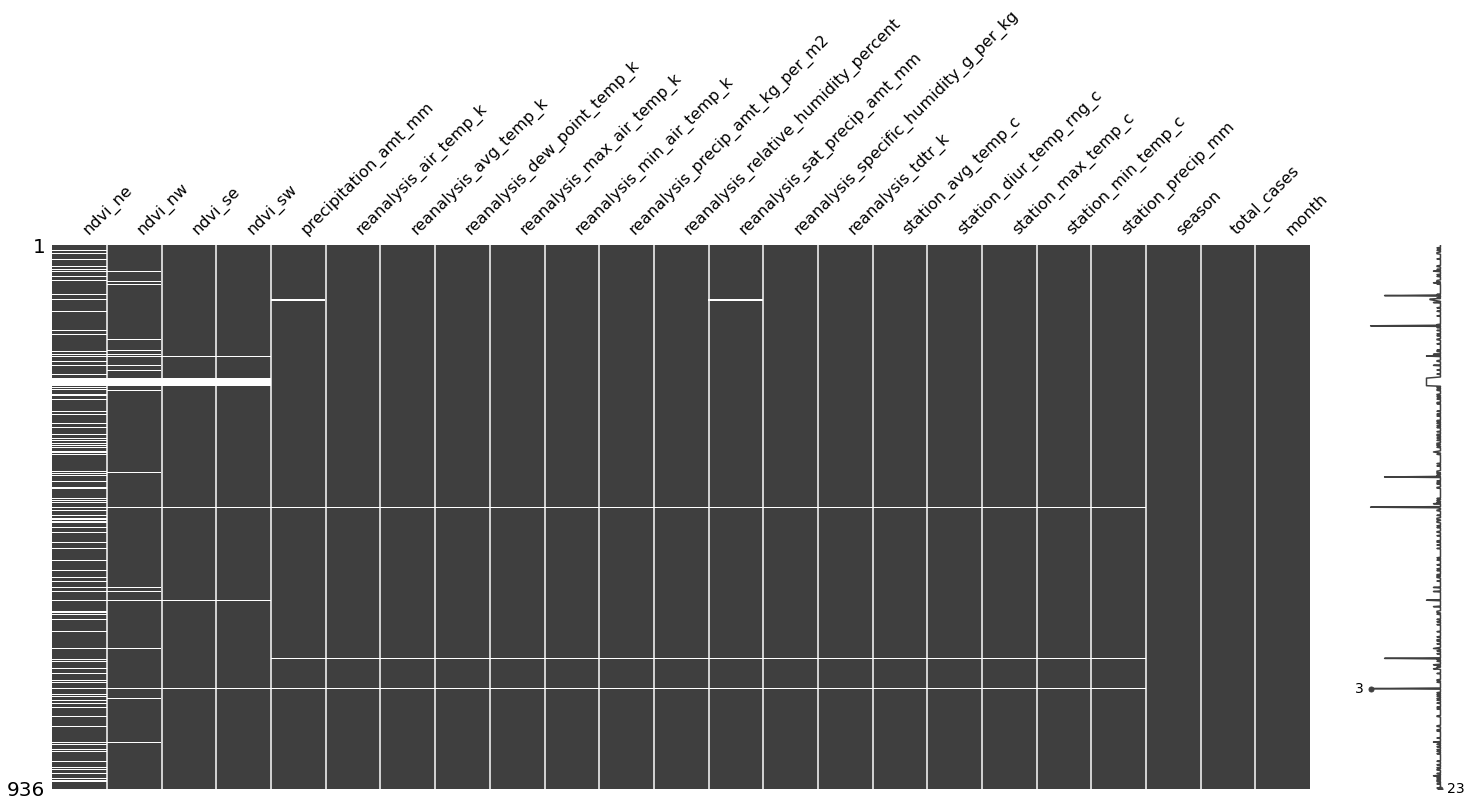

In [18]:
#Identifying sequential missing values
msno.matrix(sj_train_data)

<AxesSubplot:>

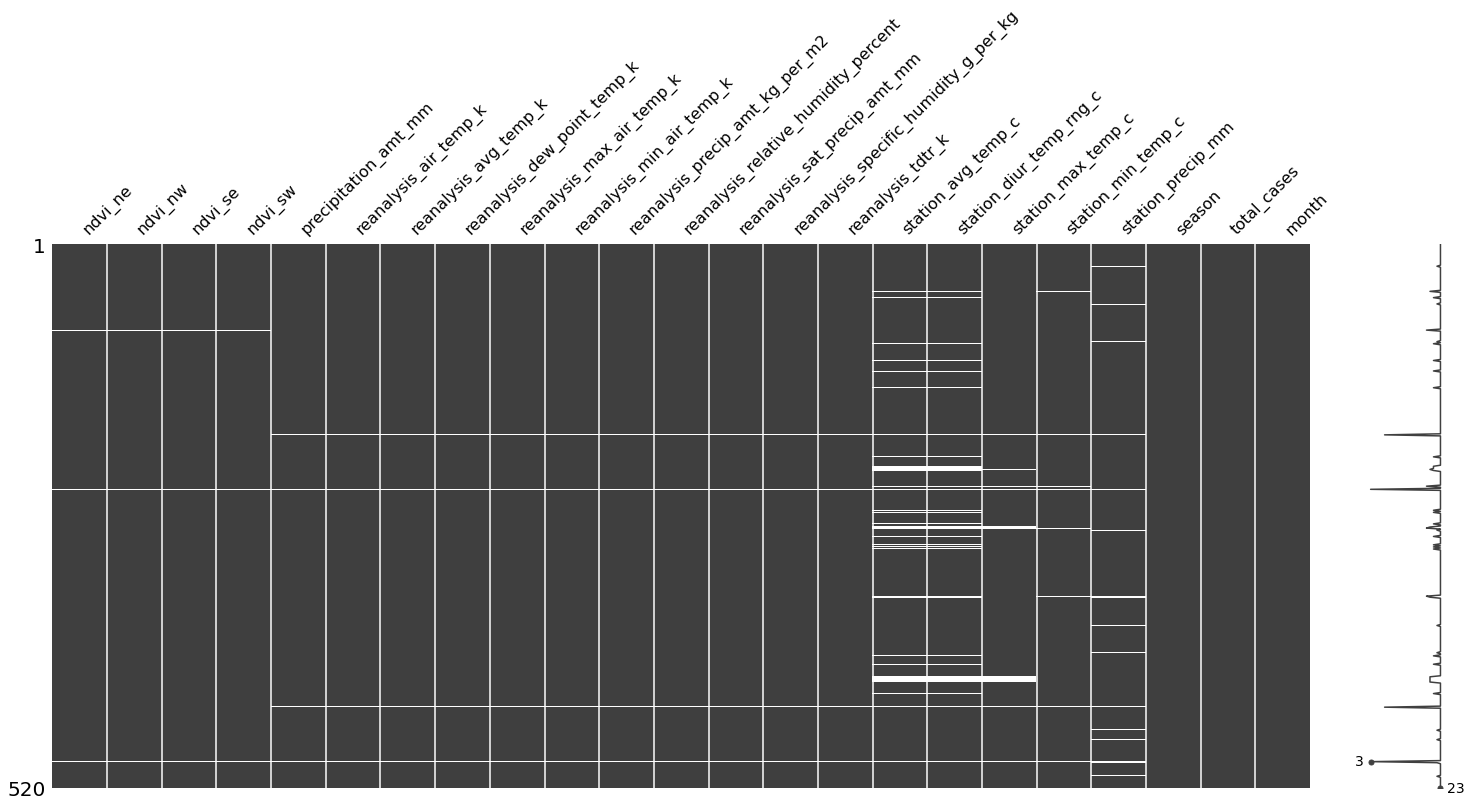

In [19]:
msno.matrix(iq_train_data)

In [20]:
#Takes testing features as input and returns transformed testing features
def testing_data_processor(testing_features):
    #Copy dataframe to avoid overwriting
    processed_features = testing_features.copy()
    processed_features['week_start_date'] = pd.to_datetime(processed_features['week_start_date'])
    processed_features['month'] = processed_features['week_start_date'].dt.month
    
    # Convert temperature from Kelvin to Celsius
    for column in ['reanalysis_max_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_air_temp_k', 
                   'reanalysis_min_air_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_tdtr_k']:
        processed_features[column] -= 273.15
        
    return processed_features

In [21]:
#Takes training data and the column to impute as input and outputs the training data with imputed col
#(as performed by the grid-searched Random Forest Regressor)
def imputation_function(train_data, imp_col):
    float_columns = train_data.select_dtypes(include=['float64']).columns.tolist()
    int_columns = train_data.select_dtypes(include=['int64']).columns.tolist()

    #Ensure the column to impute is removed for model-based imputation
    if imp_col in int_columns:
        int_columns.remove(imp_col)
    
    #Interpolate float columns only
    train_data_float = train_data[float_columns].interpolate(method='linear', limit_direction='forward', axis=0)

    #Prepare features and target where target is `imp_col`
    X = train_data_float.drop(columns=[imp_col], errors='ignore')
    y = train_data_float[imp_col] if imp_col in train_data_float.columns else None

    #Define the estimator for imputation
    if y is not None and not y.dropna().empty:
        estimator = RandomForestRegressor(random_state=42)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }

        grid_search = GridSearchCV(
            estimator=estimator, 
            param_grid=param_grid, 
            cv=5,
            n_jobs=-1,
            scoring='neg_mean_squared_error'
        )

        grid_search.fit(X, y.dropna())
        best_params = grid_search.best_params_
        estimator = RandomForestRegressor(**best_params, random_state=42)

        #Use IterativeImputer for imputing missing values in `imp_col`
        imputer = IterativeImputer(estimator=estimator, random_state=0)
        imputed_data = imputer.fit_transform(train_data_float)

        #Update the train_data with imputed values
        train_data_imputed_float = pd.DataFrame(imputed_data, columns=float_columns, index=train_data.index)
    else:
        #If no imputation is needed, use the original float data
        train_data_imputed_float = train_data_float

    #Reconstruct the full dataset with both int and float columns
    train_data_imputed = pd.concat([train_data_imputed_float, train_data[int_columns]], axis=1)

    return train_data_imputed

In [23]:
#Impute training data
sj_training_data_imputed = imputation_function(sj_train_data, 'ndvi_ne')
iq_training_data_imputed = imputation_function(iq_train_data, 'station_diur_temp_rng_c')

#Preprocess testing data
sj_testing_data = testing_data_processor(sj_test_features)
iq_testing_data = testing_data_processor(iq_test_features)

In [24]:
#Visualize imputation
sj_training_data_imputed

ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  precipitation_amt_mm  \
year weekofyear                                                                 
1990 18          0.122600  0.103725  0.198483  0.177617                 12.42   
     19          0.169900  0.142175  0.162357  0.155486                 22.82   
     20          0.032250  0.172967  0.157200  0.170843                 34.54   
     21          0.128633  0.245067  0.227557  0.235886                 15.36   
     22          0.196200  0.262200  0.251200  0.247340                  7.52   
...                   ...       ...       ...       ...                   ...   
2008 13          0.077850 -0.039900  0.310471  0.296243                 27.19   
     14         -0.038000 -0.016833  0.119371  0.066386                  3.82   
     15         -0.155200 -0.052750  0.137757  0.141214                 16.96   
     16          0.001800 -0.031558  0.203900  0.209843                  0.00   
     17         -0.037000 -0.010367  0.077314  0.090586                  0.00   

                 reanalysis_air_temp_k  reanalysis_avg_temp_k  \
year weekofyear                                                 
1990 18                      24.422857              24.592857   
     19                      25.061429              25.292857   
     20                      25.631429              25.728571   
     21                      25.837143              26.078571   
     22                      26.368571              26.514286   
...                                ...                    ...   
2008 13                      23.808571              23.807143   
     14                      24.931429              25.078571   
     15                      24.310000              24.414286   
     16                      24.480000              24.628571   
     17                      25.522857              25.542857   

                 reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
year weekofyear                                                           
1990 18                            19.264286                      26.65   
     19                            20.801429                      27.75   
     20                            22.284286                      27.35   
     21                            22.160000                      28.25   
     22                            22.671429                      28.75   
...                                      ...                        ...   
2008 13                            18.945714                      26.55   
     14                            20.085714                      26.65   
     15                            19.582857                      26.25   
     16                            19.124286                      26.55   
     17                            21.130000                      27.75   

                 reanalysis_min_air_temp_k  ...  \
year weekofyear                             ...   
1990 18                              22.75  ...   
     19                              23.25  ...   
     20                              24.15  ...   
     21                              23.85  ...   
     22                              24.35  ...   
...                                    ...  ...   
2008 13                              21.25  ...   
     14                              23.35  ...   
     15                              22.65  ...   
     16                              22.75  ...   
     17                              22.75  ...   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
year weekofyear                                                             
1990 18                                      14.012857        -270.521429   
     19                                      15.372857        -270.778571   
     20                                      16.848571        -270.850000   
     21                                      16.672857        -270.721429   
     22         

In [25]:
iq_training_data_imputed

ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  precipitation_amt_mm  \
year weekofyear                                                                 
2000 26          0.192886  0.132257  0.340886  0.247200                 25.41   
     27          0.216833  0.276100  0.289457  0.241657                 60.61   
     28          0.176757  0.173129  0.204114  0.128014                 55.52   
     29          0.227729  0.145429  0.254200  0.200314                  5.60   
     30          0.328643  0.322129  0.254371  0.361043                 62.76   
...                   ...       ...       ...       ...                   ...   
2010 21          0.342750  0.318900  0.256343  0.292514                 55.30   
     22          0.160157  0.160371  0.136043  0.225657                 86.47   
     23          0.247057  0.146057  0.250357  0.233714                 58.94   
     24          0.333914  0.245771  0.278886  0.325486                 59.67   
     25          0.298186  0.232971  0.274214  0.315757                 63.22   

                 reanalysis_air_temp_k  reanalysis_avg_temp_k  \
year weekofyear                                                 
2000 26                      23.590000              25.300000   
     27                      23.484286              25.278571   
     28                      23.265714              24.242857   
     29                      22.207143              23.078571   
     30                      23.282857              24.485714   
...                                ...                    ...   
2010 21                      26.184286              27.621429   
     22                      25.180000              26.242857   
     23                      23.448571              24.442857   
     24                      23.195714              24.371429   
     25                      24.947143              26.685714   

                 reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
year weekofyear                                                           
2000 26                            22.034286                      34.15   
     27                            22.208571                      33.45   
     28                            22.472857                      31.35   
     29                            19.647143                      30.45   
     30                            20.807143                      33.85   
...                                      ...                        ...   
2010 21                            23.675714                      36.55   
     22                            23.302857                      35.35   
     23                            22.351429                      32.35   
     24                            22.174286                      32.95   
     25                            22.657143                      34.65   

                 reanalysis_min_air_temp_k  ...  \
year weekofyear                             ...   
2000 26                              19.95  ...   
     27                              17.95  ...   
     28                              19.45  ...   
     29                              15.45  ...   
     30                              18.35  ...   
...                                    ...  ...   
2010 21                              21.35  ...   
     22                              18.75  ...   
     23                              19.25  ...   
     24                              18.75  ...   
     25                              19.15  ...   

                 reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
year weekofyear                                                             
2000 26                                      16.651429        -264.221429   
     27                                      16.862857        -262.835714   
     28                                      17.120000        -265.764286   
     29                                      14.431429        -264.035714   
     30         

In [26]:
#Print percentage of null values per feature after imputation
sj_null_means_imputed = sj_training_data_imputed.isnull().mean().sort_values(ascending=False)
iq_null_means_imputed = iq_training_data_imputed.isnull().mean().sort_values(ascending=False)

print('San Juan Missing Training Data Percentage:\n')
print(sj_null_means_imputed)
print('\n' + '-' * 50 + '\n') 
print('Iquitos Missing Training Data Percentage:\n')
print(iq_null_means_imputed)

San Juan Missing Training Data Percentage:

ndvi_ne                                  0.0
reanalysis_sat_precip_amt_mm             0.0
total_cases                              0.0
season                                   0.0
station_precip_mm                        0.0
station_min_temp_c                       0.0
station_max_temp_c                       0.0
station_diur_temp_rng_c                  0.0
station_avg_temp_c                       0.0
reanalysis_tdtr_k                        0.0
reanalysis_specific_humidity_g_per_kg    0.0
reanalysis_relative_humidity_percent     0.0
ndvi_nw                                  0.0
reanalysis_precip_amt_kg_per_m2          0.0
reanalysis_min_air_temp_k                0.0
reanalysis_max_air_temp_k                0.0
reanalysis_dew_point_temp_k              0.0
reanalysis_avg_temp_k                    0.0
reanalysis_air_temp_k                    0.0
precipitation_amt_mm                     0.0
ndvi_sw                                  0.0
ndvi_se    

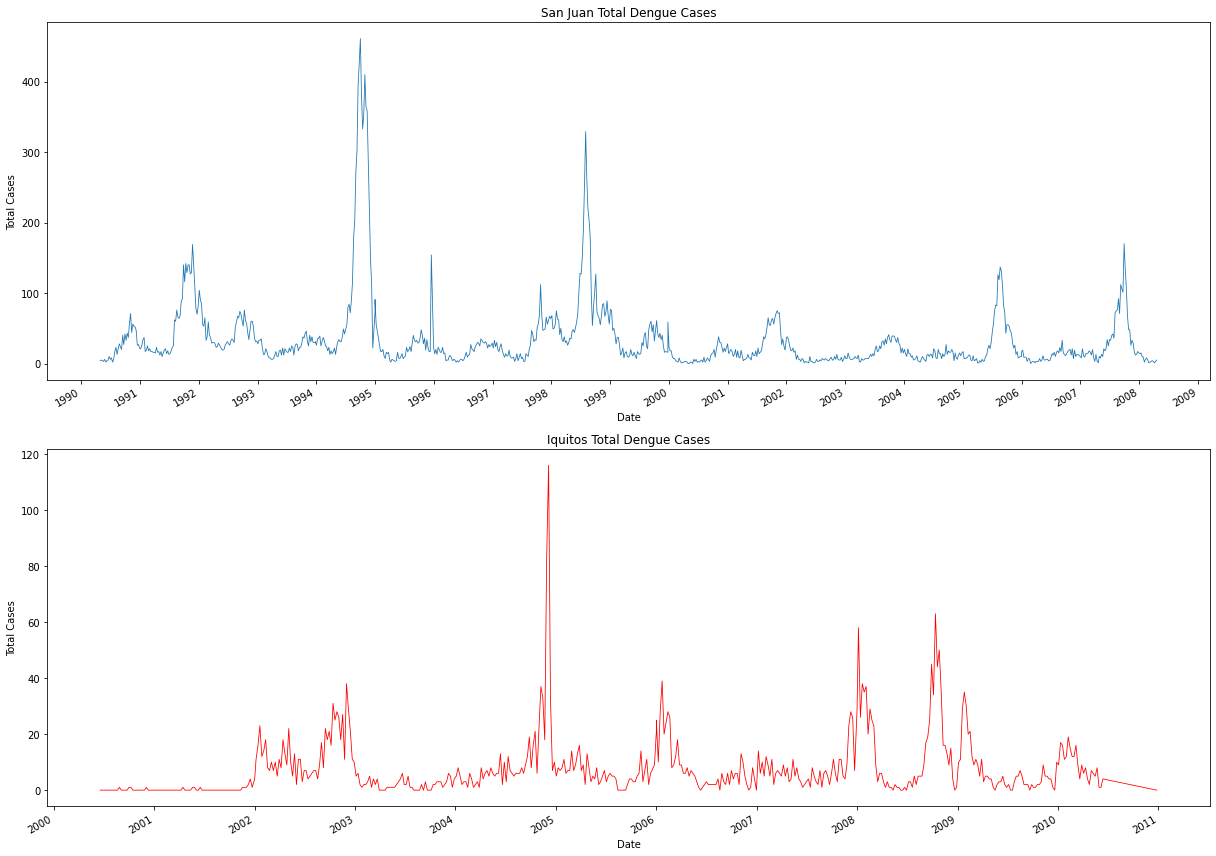

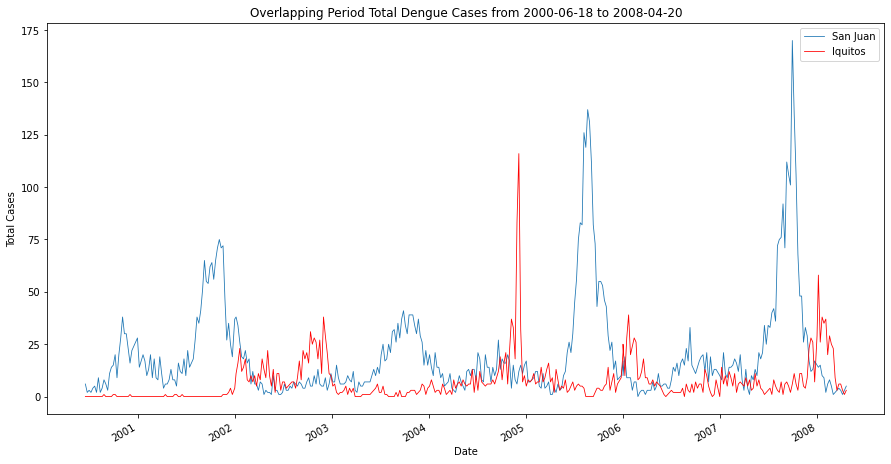

In [48]:
#Plotting total_cases by year for each city
plt.figure(figsize=(17, 12))

#Plot for San Juan
plt.subplot(2, 1, 1)
sj_train_labels.total_cases.plot(lw=0.8)
plt.title('San Juan Total Dengue Cases')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


#Plot for Iquitos
plt.subplot(2, 1, 2)
iq_train_labels.total_cases.plot(lw=0.8, color='r')
plt.title('Iquitos Total Dengue Cases')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.subplots_adjust(hspace=5.0)
plt.tight_layout()
plt.show()

#Prepare data for the overlapping period
sj_train_labels = sj_train_labels.reset_index()
iq_train_labels = iq_train_labels.reset_index()

#Create 'date' column based on 'year' and 'weekofyear'
sj_train_labels['date'] = pd.to_datetime(sj_train_labels['year'].astype(str) + '-' + (sj_train_labels['weekofyear']-1).astype(str) + '-0', format='%Y-%U-%w')
iq_train_labels['date'] = pd.to_datetime(iq_train_labels['year'].astype(str) + '-' + (iq_train_labels['weekofyear']-1).astype(str) + '-0', format='%Y-%U-%w')

sj_train_labels.set_index('date', inplace=True)
iq_train_labels.set_index('date', inplace=True)

#Find the overlapping date range
common_start = max(sj_train_labels.index.min(), iq_train_labels.index.min())
common_end = min(sj_train_labels.index.max(), iq_train_labels.index.max())

#Filter data for the overlapping range
sj_overlapping = sj_train_labels.loc[common_start:common_end]
iq_overlapping = iq_train_labels.loc[common_start:common_end]

#Plot for the overlapping period
plt.figure(figsize=(15, 8))
sj_overlapping.total_cases.plot(lw=0.8, label='San Juan')
iq_overlapping.total_cases.plot(lw=0.8, color='r', label='Iquitos')
plt.title(f'Overlapping Period Total Dengue Cases from {common_start.strftime("%Y-%m-%d")} to {common_end.strftime("%Y-%m-%d")}')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.legend()

#Set x-axis major tick locator to yearly and formatter to show the year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

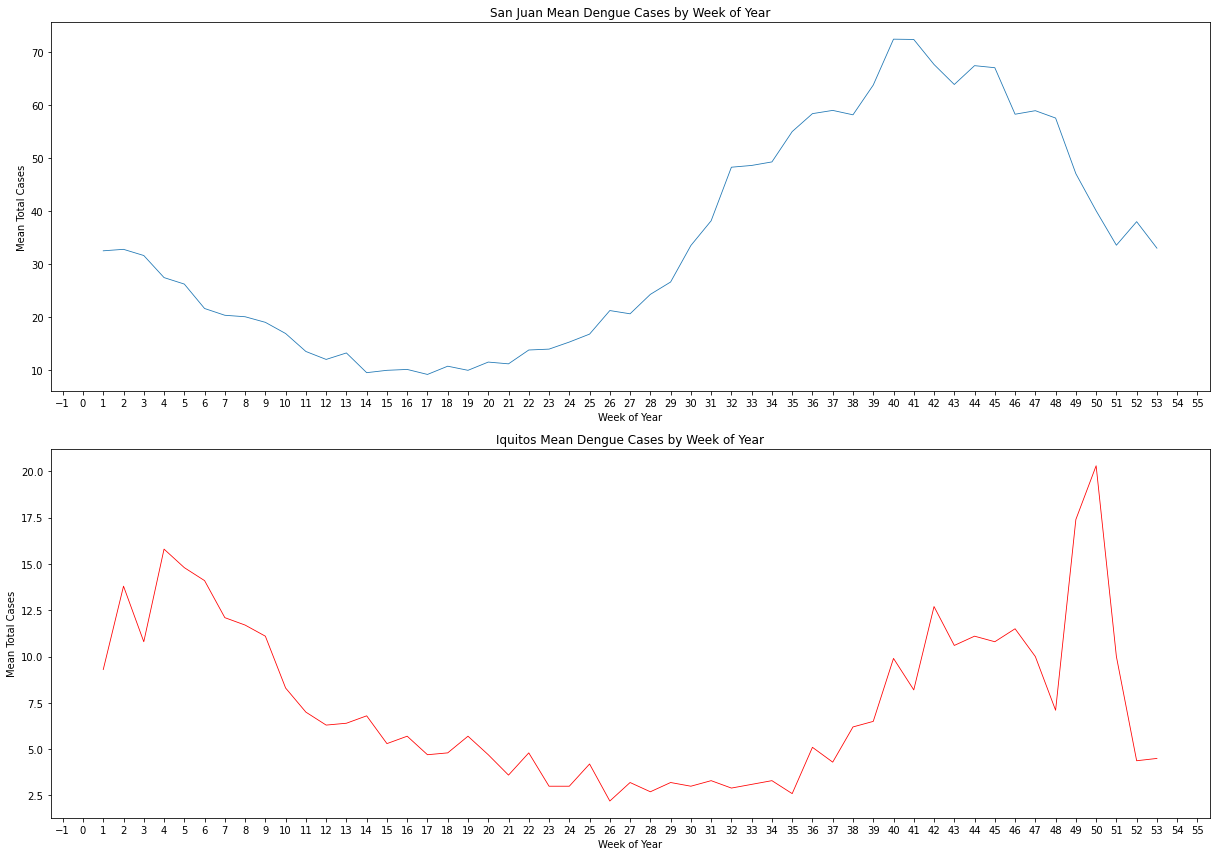

In [32]:
#Plotting the mean total_cases by weekokfyear to examine seasonality
sj_mean_cases = sj_train_labels.groupby('weekofyear')['total_cases'].mean()
iq_mean_cases = iq_train_labels.groupby('weekofyear')['total_cases'].mean()

plt.figure(figsize=(17, 12))

#Plot for San Juan
plt.subplot(2, 1, 1)
plt.plot(sj_mean_cases.index, sj_mean_cases.values, lw=0.8)
plt.title('San Juan Mean Dengue Cases by Week of Year')
plt.xlabel('Week of Year')
plt.ylabel('Mean Total Cases')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

#Plot for Iquitos
plt.subplot(2, 1, 2)
plt.plot(iq_mean_cases.index, iq_mean_cases.values, lw=0.8, color='r')
plt.title('Iquitos Mean Dengue Cases by Week of Year')
plt.xlabel('Week of Year')
plt.ylabel('Mean Total Cases')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

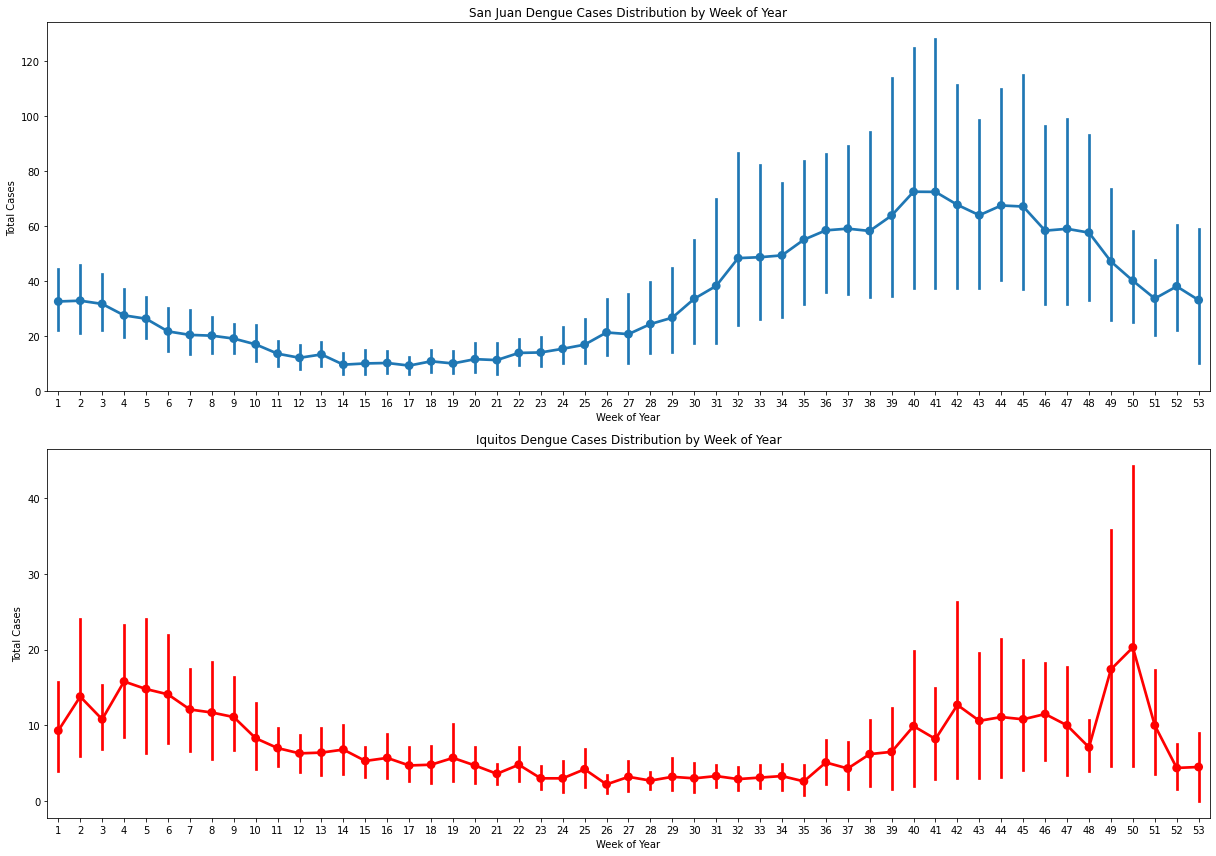

In [39]:
plt.figure(figsize=(17, 12))

#Plot for San Juan
plt.subplot(2, 1, 1)
sns.pointplot(x='weekofyear', y='total_cases', data=sj_train_labels)
plt.title('San Juan Dengue Cases Distribution by Week of Year')
plt.xlabel('Week of Year')
plt.ylabel('Total Cases')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

#Plot for Iquitos
plt.subplot(2, 1, 2)
sns.pointplot(x='weekofyear', y='total_cases', data=iq_train_labels, color='r')
plt.title('Iquitos Dengue Cases Distribution by Week of Year')
plt.xlabel('Week of Year')
plt.ylabel('Total Cases')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.tight_layout()
plt.show()

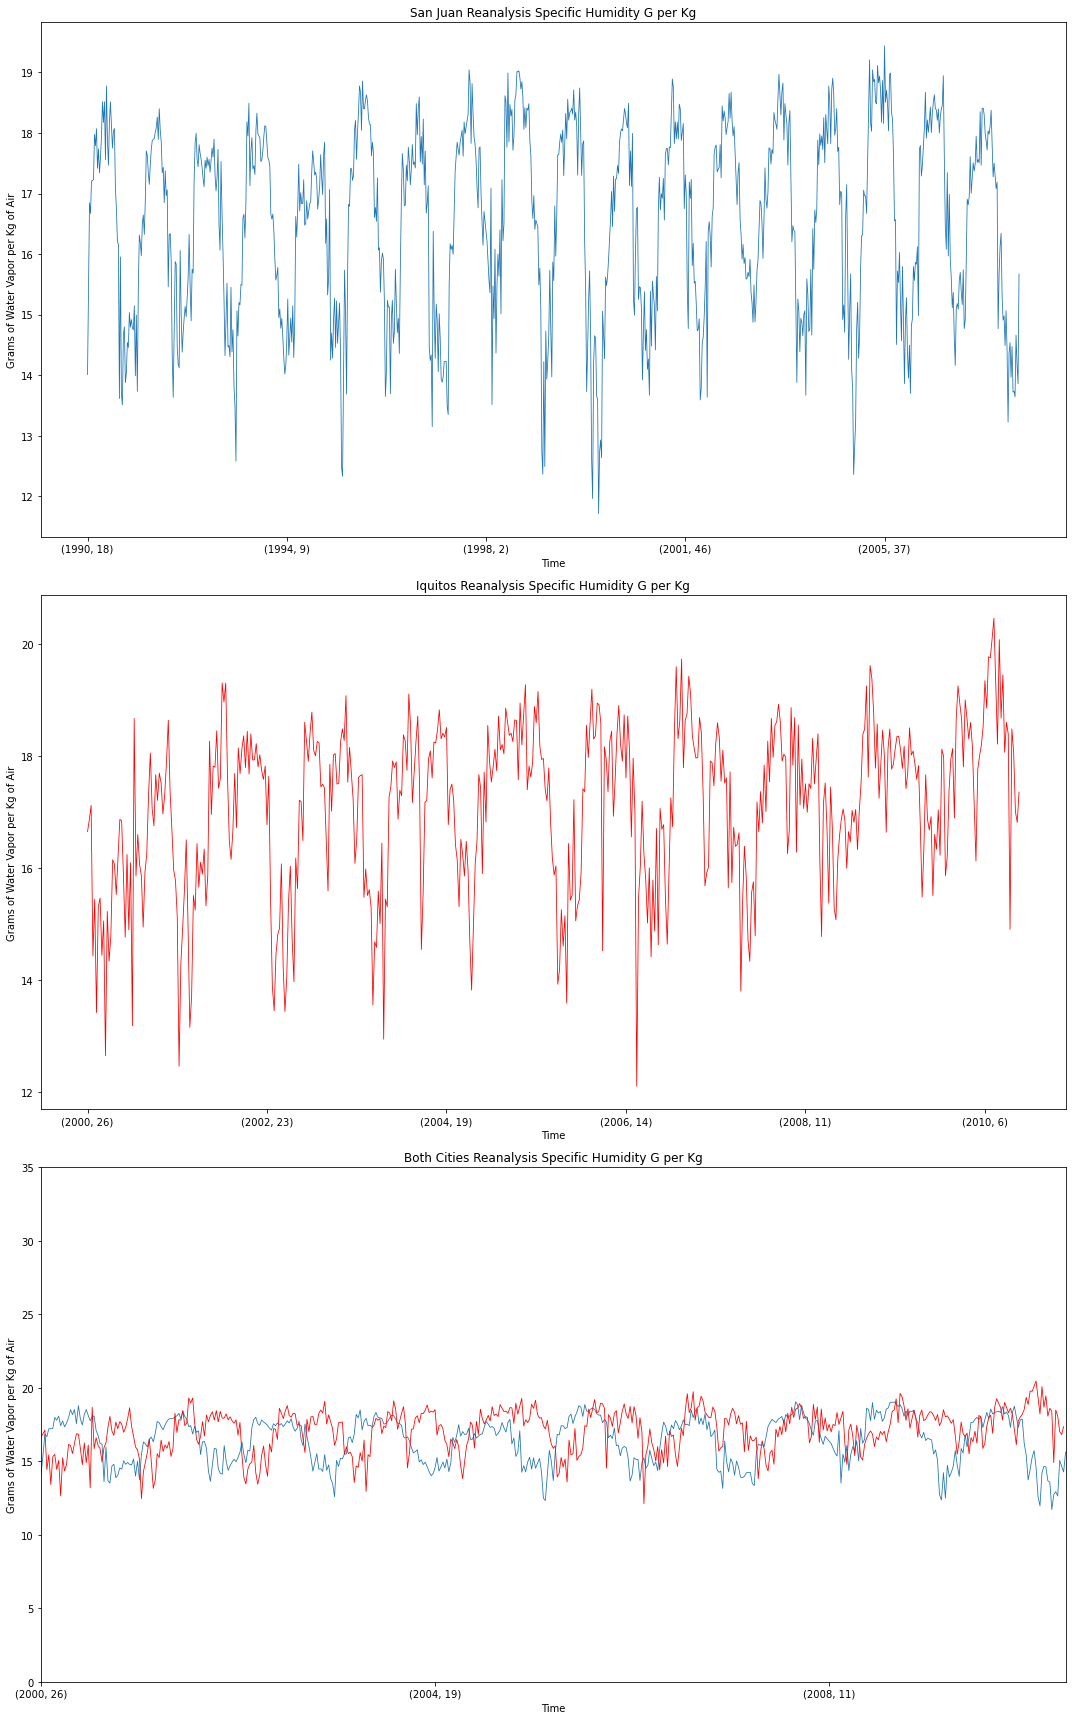

In [40]:
#Examining like features between cities
fig, axs = plt.subplots(3, 1, figsize=(15, 24))  # 3 rows, 1 column

#San Juan Reanalysis Specific Humidity G per Kg
sj_training_data_imputed.reanalysis_specific_humidity_g_per_kg.plot.line(lw=0.8, ax=axs[0])
axs[0].set_title('San Juan Reanalysis Specific Humidity G per Kg')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Grams of Water Vapor per Kg of Air')

#Iquitos Reanalysis Specific Humidity G per Kg
iq_training_data_imputed.reanalysis_specific_humidity_g_per_kg.plot.line(lw=0.8, color='r', ax=axs[1])
axs[1].set_title('Iquitos Reanalysis Specific Humidity G per Kg')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Grams of Water Vapor per Kg of Air')

#Both Cities Reanalysis Specific Humidity G per Kg
sj_training_data_imputed.reanalysis_specific_humidity_g_per_kg.plot.line(lw=0.8, ax=axs[2])
iq_training_data_imputed.reanalysis_specific_humidity_g_per_kg.plot.line(lw=0.8, color='r', ax=axs[2])
axs[2].set_xlim([0, 520])
axs[2].set_ylim([0, 35])
axs[2].set_title('Both Cities Reanalysis Specific Humidity G per Kg')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Grams of Water Vapor per Kg of Air')

plt.tight_layout()
plt.show()

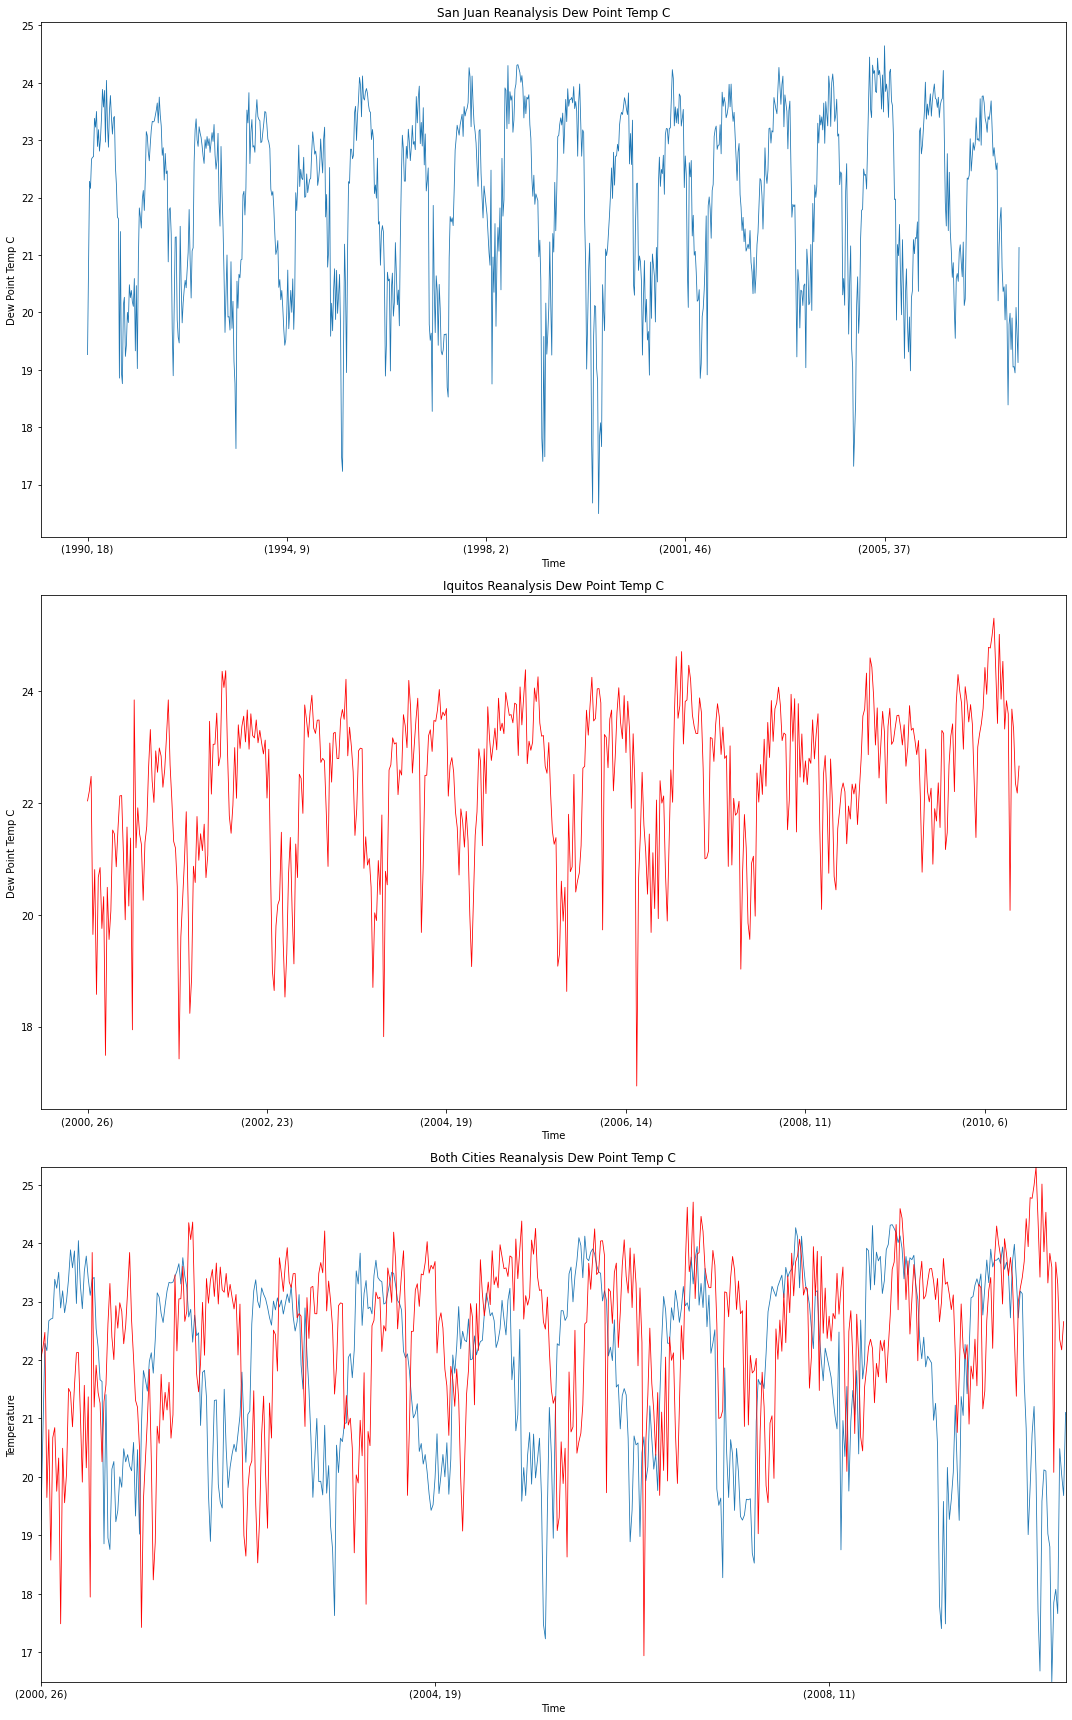

In [41]:
fig, axs = plt.subplots(3, 1, figsize=(15, 24))  # 3 rows, 1 column

#San Juan Reanalysis Dew Point Temp C
sj_training_data_imputed.reanalysis_dew_point_temp_k.plot.line(lw=0.8, ax=axs[0])
axs[0].set_title('San Juan Reanalysis Dew Point Temp C')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Dew Point Temp C')

#Iquitos Reanalysis Dew Point Temp C
iq_training_data_imputed.reanalysis_dew_point_temp_k.plot.line(lw=0.8, color='r', ax=axs[1])
axs[1].set_title('Iquitos Reanalysis Dew Point Temp C')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Dew Point Temp C')

#Both Cities Reanalysis Dew Point Temp C
sj_training_data_imputed.reanalysis_dew_point_temp_k.plot.line(lw=0.8, ax=axs[2])
iq_training_data_imputed.reanalysis_dew_point_temp_k.plot.line(lw=0.8, color='r', ax=axs[2])
axs[2].set_xlim([0, 520])
axs[2].set_ylim([sj_training_data_imputed.reanalysis_dew_point_temp_k.min(), iq_training_data_imputed.reanalysis_dew_point_temp_k.max()])
axs[2].set_title('Both Cities Reanalysis Dew Point Temp C')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Temperature')

plt.tight_layout()
plt.show()

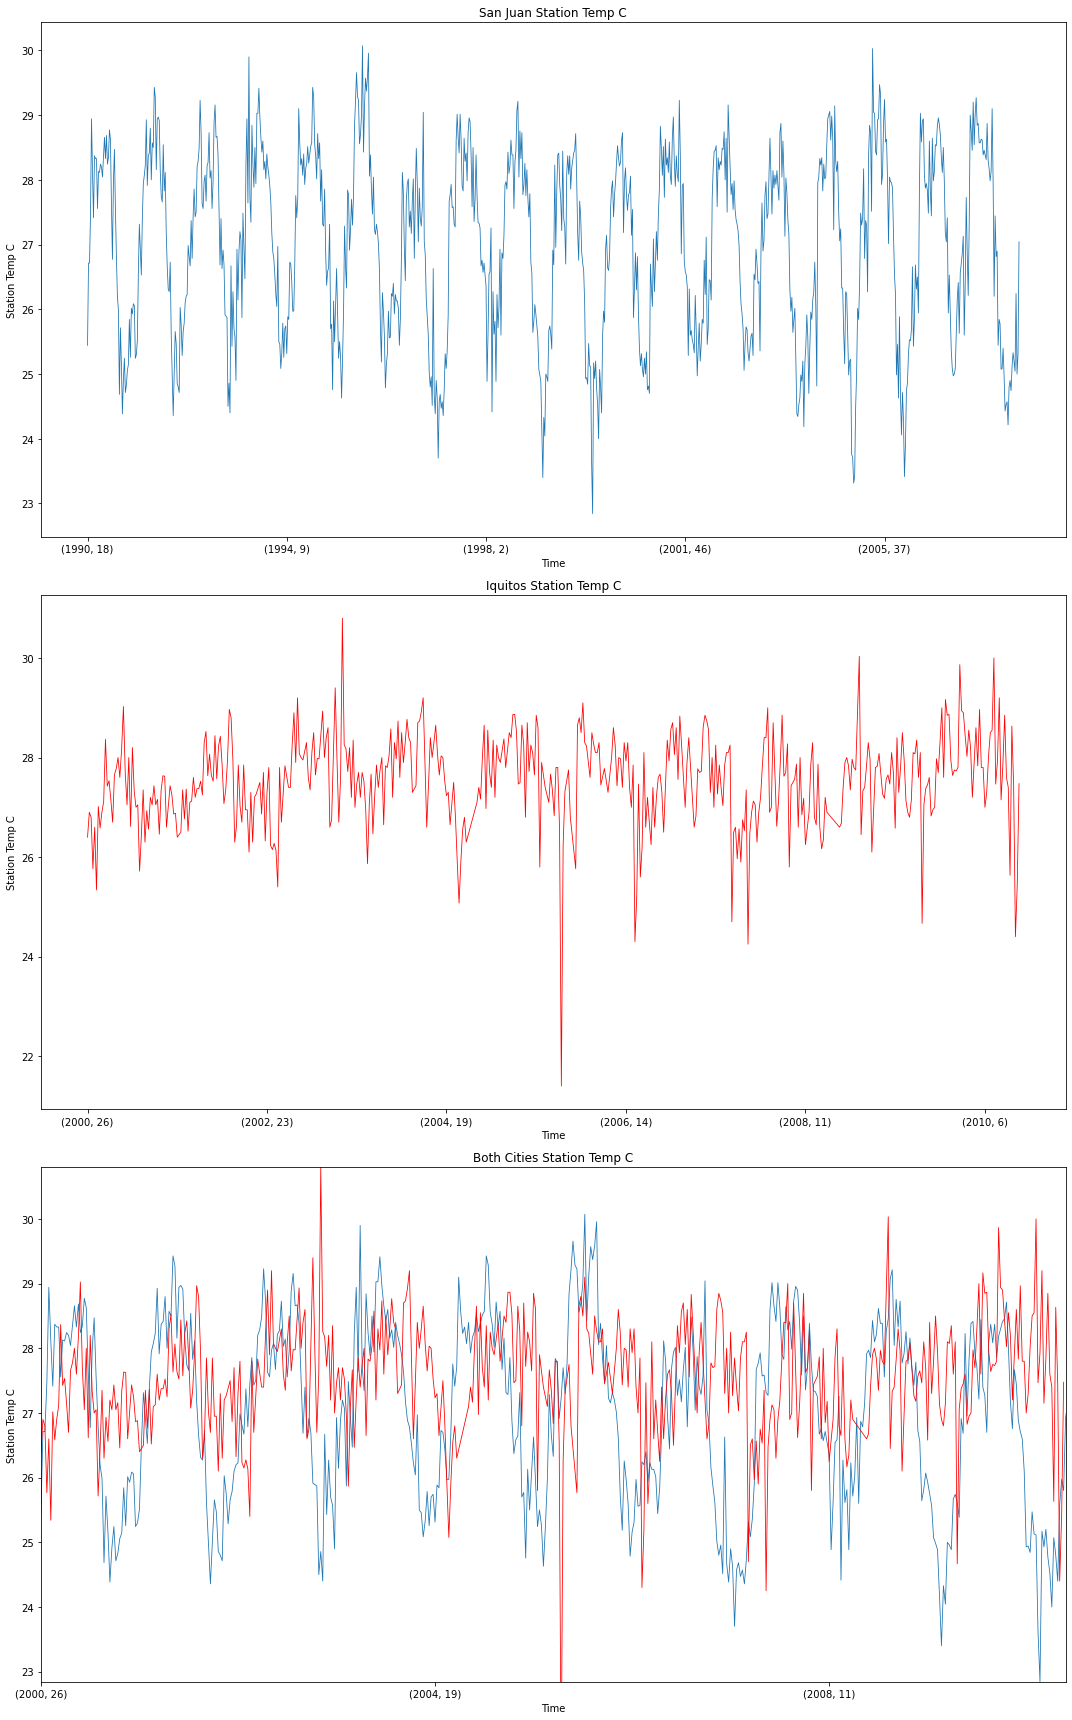

In [42]:
fig, axs = plt.subplots(3, 1, figsize=(15, 24))  # 3 rows, 1 column

#San Juan Station Temp C
sj_training_data_imputed.station_avg_temp_c.plot.line(lw=0.8, ax=axs[0])
axs[0].set_title('San Juan Station Temp C')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Station Temp C')

#Iquitos Station Temp C
iq_training_data_imputed.station_avg_temp_c.plot.line(lw=0.8, color='r', ax=axs[1])
axs[1].set_title('Iquitos Station Temp C')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Station Temp C')

#Both Cities Station Temp C
sj_training_data_imputed.station_avg_temp_c.plot.line(lw=0.8, ax=axs[2])
iq_training_data_imputed.station_avg_temp_c.plot.line(lw=0.8, color='r', ax=axs[2])
axs[2].set_xlim([0, 520])
axs[2].set_ylim([sj_training_data_imputed.station_avg_temp_c.min(), iq_training_data_imputed.station_avg_temp_c.max()])
axs[2].set_title('Both Cities Station Temp C')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Station Temp C')

plt.tight_layout()
plt.show()

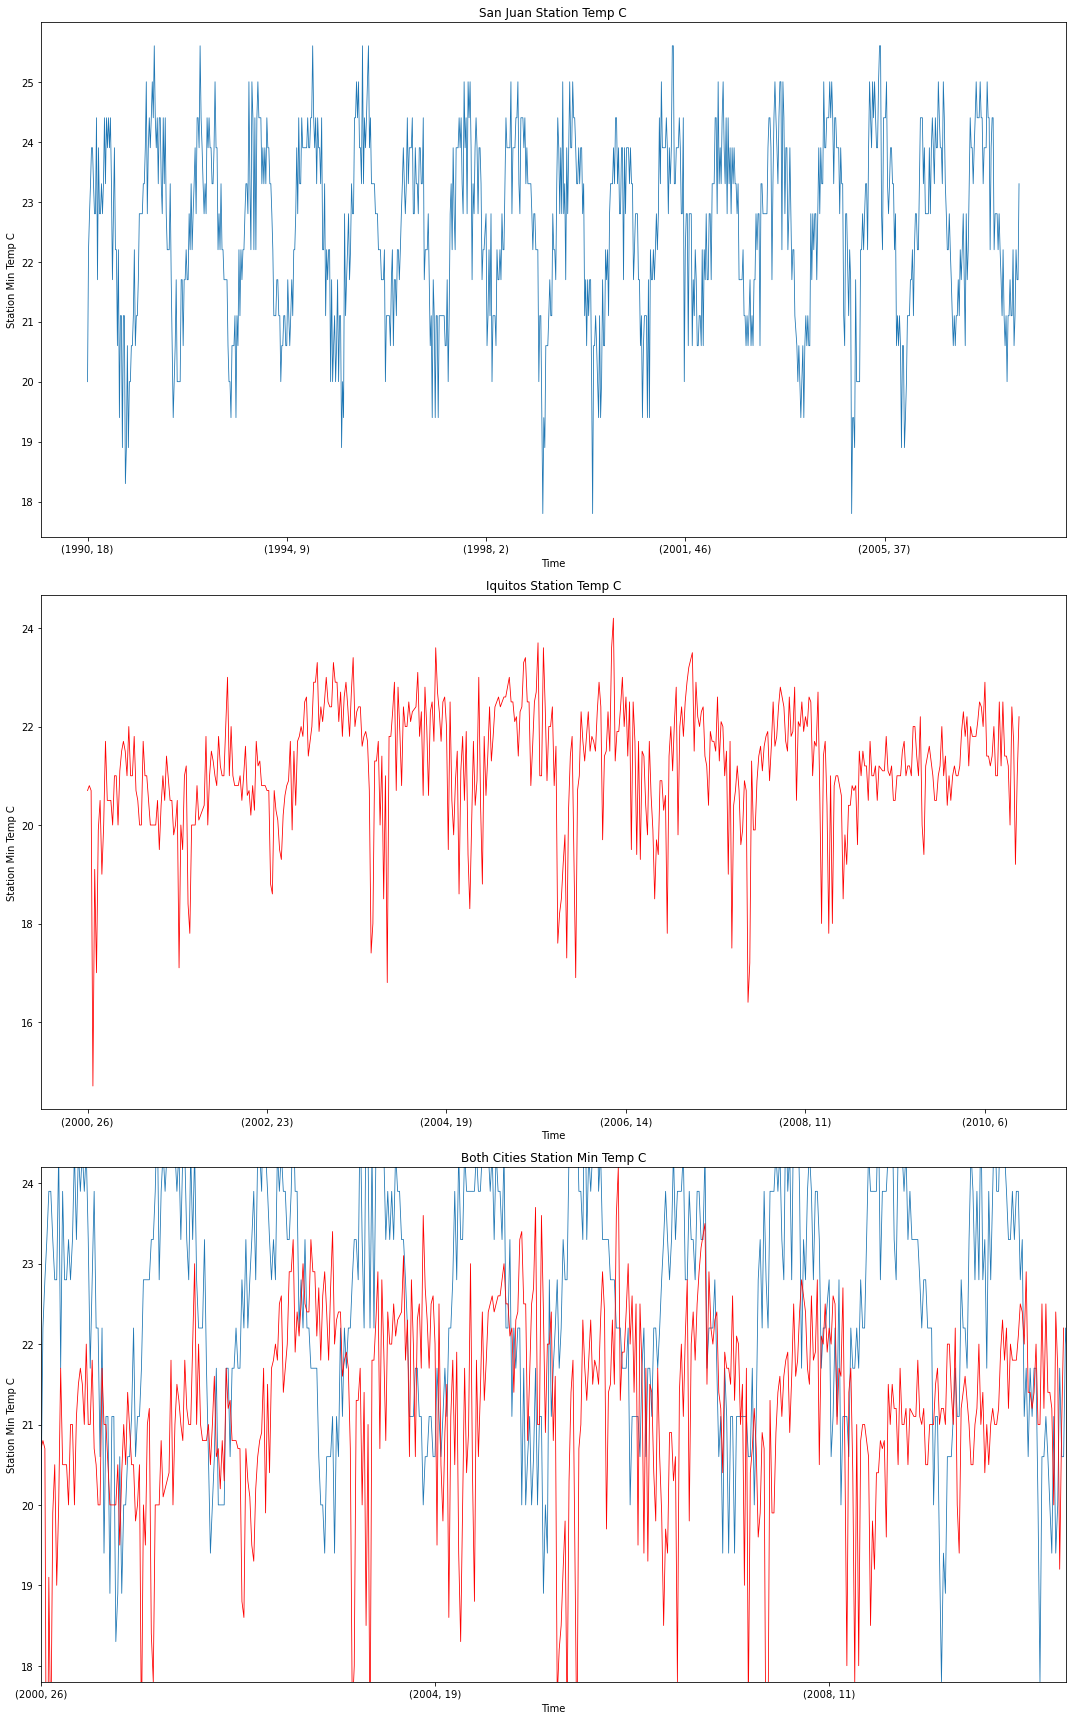

In [43]:
fig, axs = plt.subplots(3, 1, figsize=(15, 24))

#San Juan Station Min Temp C
sj_training_data_imputed.station_min_temp_c.plot.line(lw=0.8, ax=axs[0])
axs[0].set_title('San Juan Station Temp C')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Station Min Temp C')

#Iquitos Station Min Temp C
iq_training_data_imputed.station_min_temp_c.plot.line(lw=0.8, color='r', ax=axs[1])
axs[1].set_title('Iquitos Station Temp C')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Station Min Temp C')

#Both Cities Station Min Temp C
sj_training_data_imputed.station_min_temp_c.plot.line(lw=0.8, ax=axs[2])
iq_training_data_imputed.station_min_temp_c.plot.line(lw=0.8, color='r', ax=axs[2])
axs[2].set_xlim([0, 520])
axs[2].set_ylim([sj_training_data_imputed.station_min_temp_c.min(), iq_training_data_imputed.station_min_temp_c.max()])
axs[2].set_title('Both Cities Station Min Temp C')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Station Min Temp C')

plt.tight_layout()
plt.show()

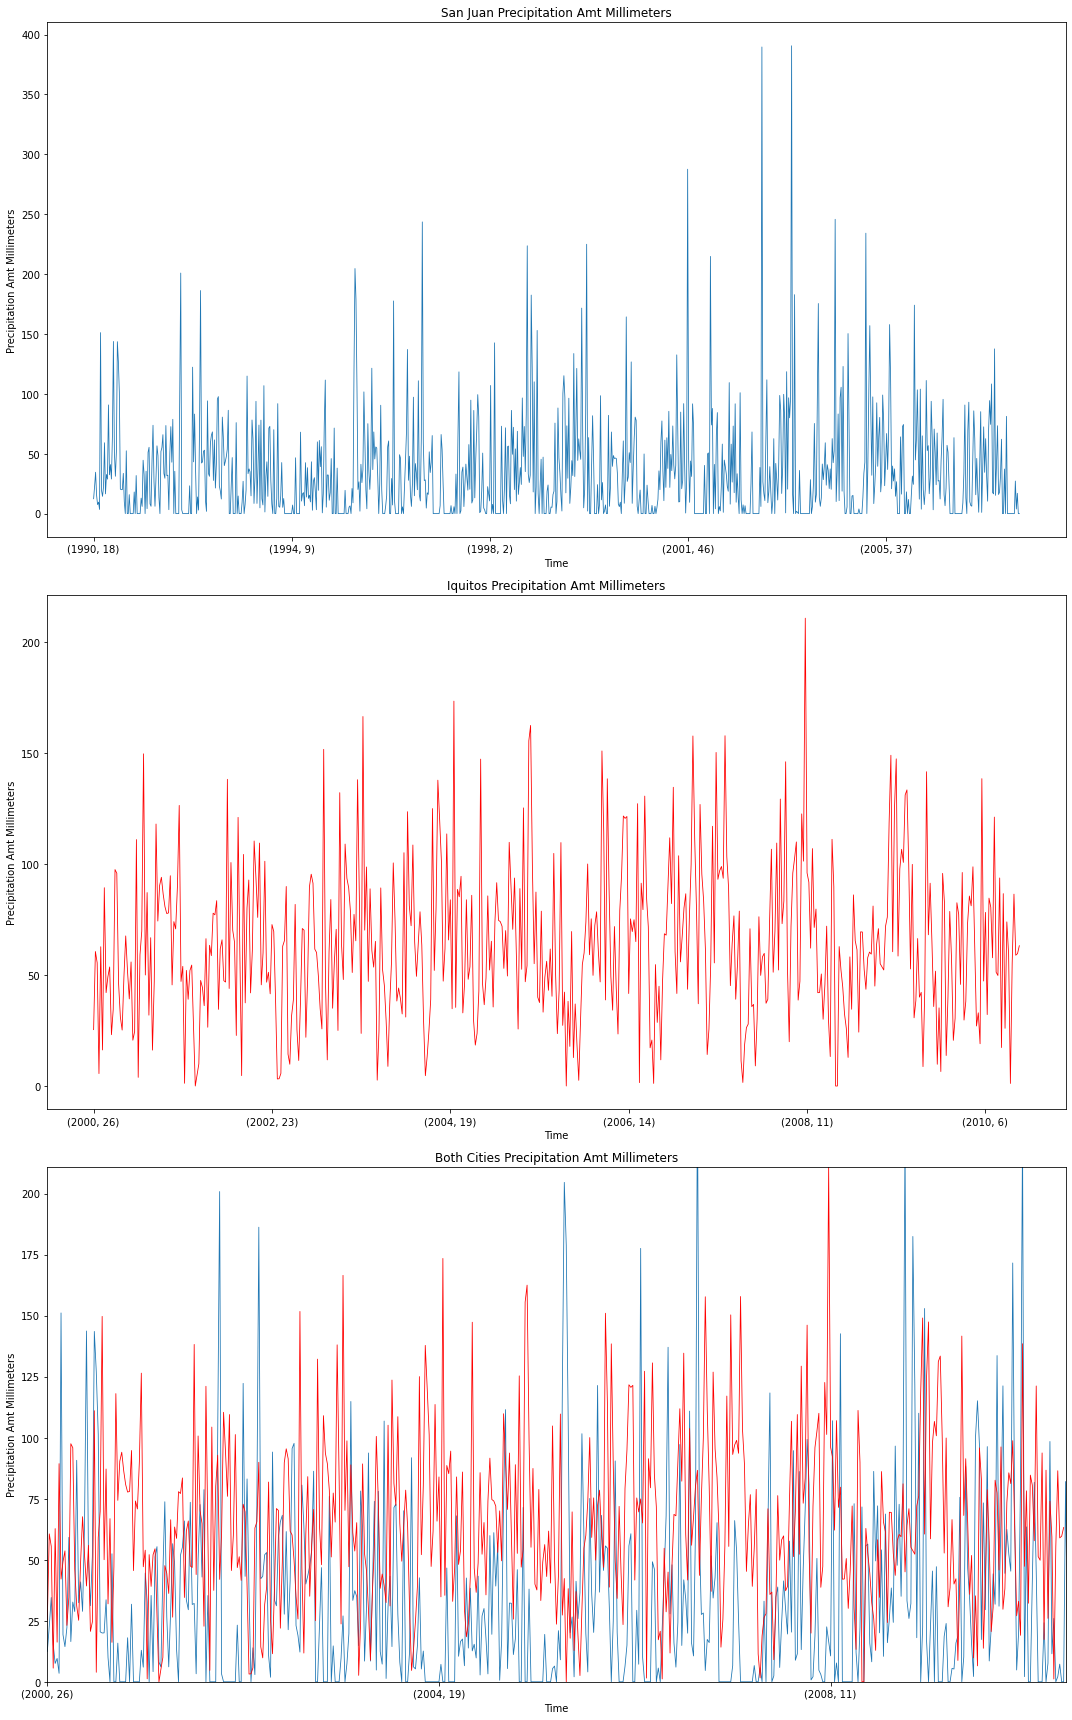

In [44]:
fig, axs = plt.subplots(3, 1, figsize=(15, 24))

#San Juan Precipitation Amt Millimeters
sj_training_data_imputed.precipitation_amt_mm.plot.line(lw=0.8, ax=axs[0])
axs[0].set_title('San Juan Precipitation Amt Millimeters')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Precipitation Amt Millimeters')

#Iquitos Precipitation Amt Millimeters
iq_training_data_imputed.precipitation_amt_mm.plot.line(lw=0.8, color='r', ax=axs[1])
axs[1].set_title('Iquitos Precipitation Amt Millimeters')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Precipitation Amt Millimeters')

#Both Cities Precipitation Amt Millimeters
sj_training_data_imputed.precipitation_amt_mm.plot.line(lw=0.8, ax=axs[2])
iq_training_data_imputed.precipitation_amt_mm.plot.line(lw=0.8, color='r', ax=axs[2])
axs[2].set_xlim([0, 520])
axs[2].set_ylim([sj_training_data_imputed.precipitation_amt_mm.min(), iq_training_data_imputed.precipitation_amt_mm.max()])
axs[2].set_title('Both Cities Precipitation Amt Millimeters')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Precipitation Amt Millimeters')

plt.tight_layout()
plt.show()

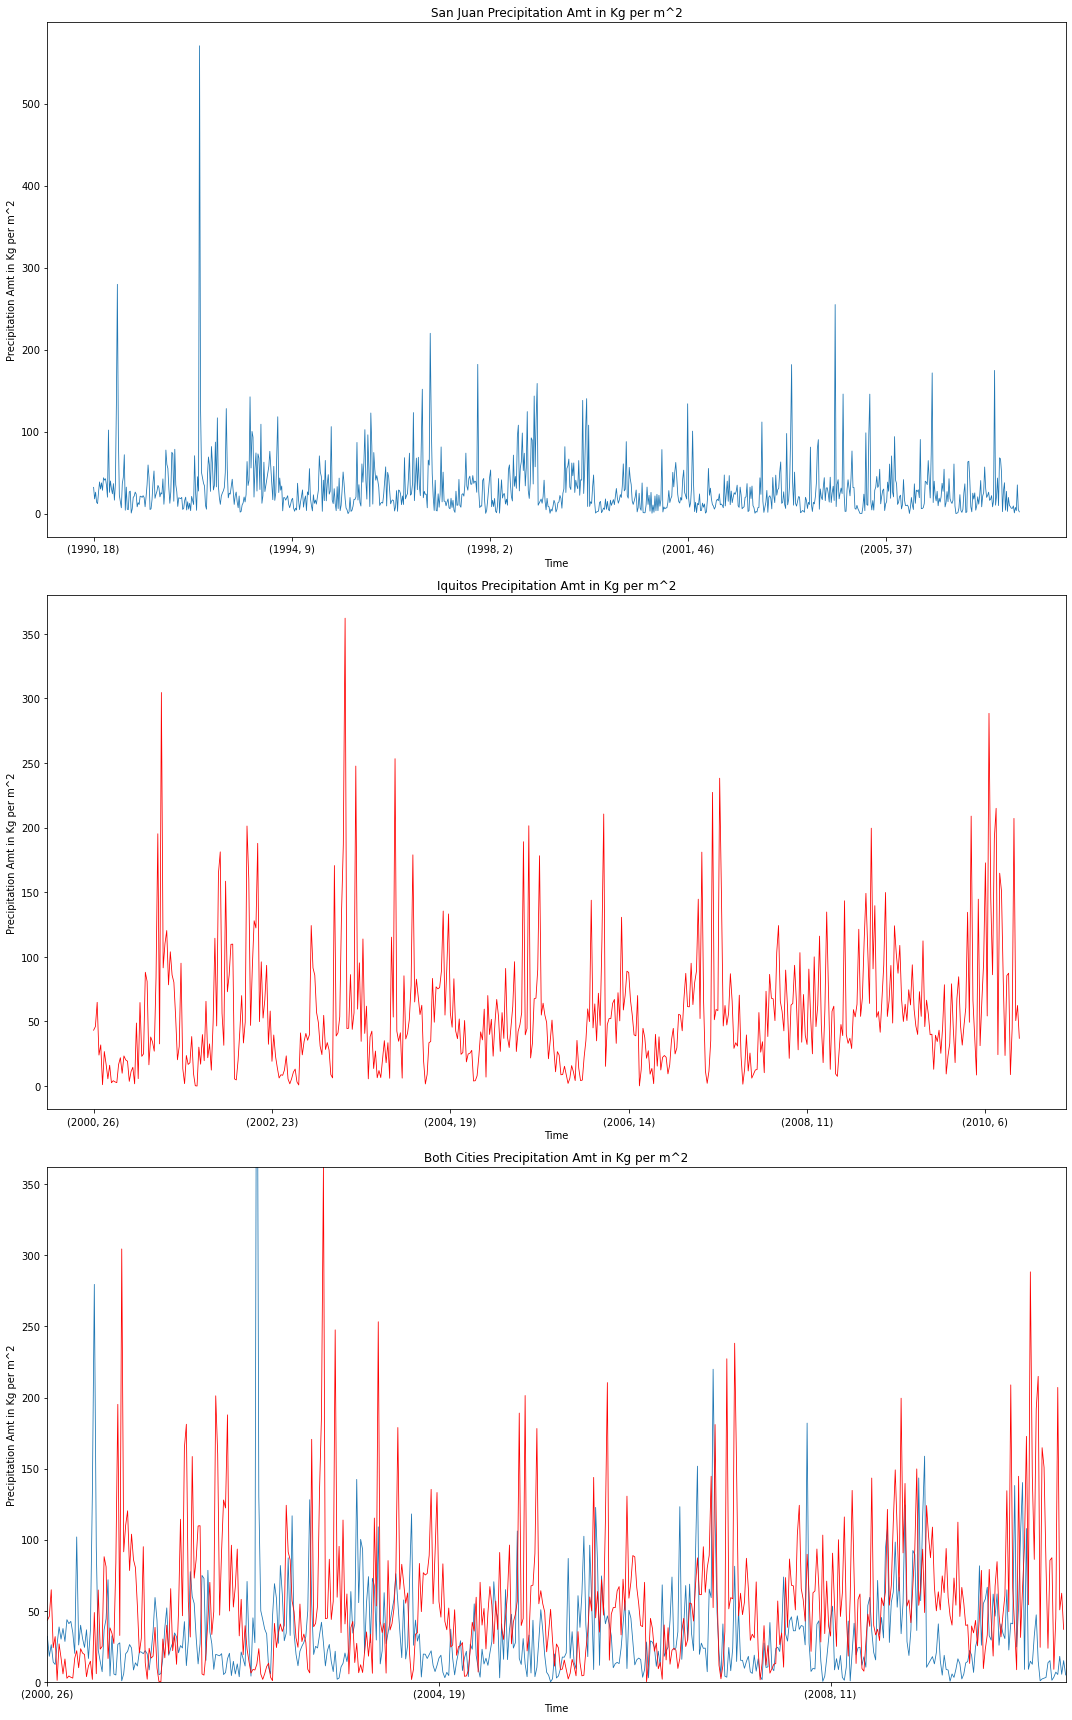

In [45]:
fig, axs = plt.subplots(3, 1, figsize=(15, 24))

#San Juan Precipitation Amt in Kg per m^2
sj_training_data_imputed.reanalysis_precip_amt_kg_per_m2.plot.line(lw=0.8, ax=axs[0])
axs[0].set_title('San Juan Precipitation Amt in Kg per m^2')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Precipitation Amt in Kg per m^2')

#Iquitos Precipitation Amt in Kg per m^2
iq_training_data_imputed.reanalysis_precip_amt_kg_per_m2.plot.line(lw=0.8, color='r', ax=axs[1])
axs[1].set_title('Iquitos Precipitation Amt in Kg per m^2')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Precipitation Amt in Kg per m^2')

#Both Cities Precipitation in Kg per m^2
sj_training_data_imputed.reanalysis_precip_amt_kg_per_m2.plot.line(lw=0.8, ax=axs[2])
iq_training_data_imputed.reanalysis_precip_amt_kg_per_m2.plot.line(lw=0.8, color='r', ax=axs[2])
axs[2].set_xlim([0, 520])
axs[2].set_ylim([sj_training_data_imputed.reanalysis_precip_amt_kg_per_m2.min(), iq_training_data_imputed.reanalysis_precip_amt_kg_per_m2.max()])
axs[2].set_title('Both Cities Precipitation Amt in Kg per m^2')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Precipitation Amt in Kg per m^2')

plt.tight_layout()
plt.show()

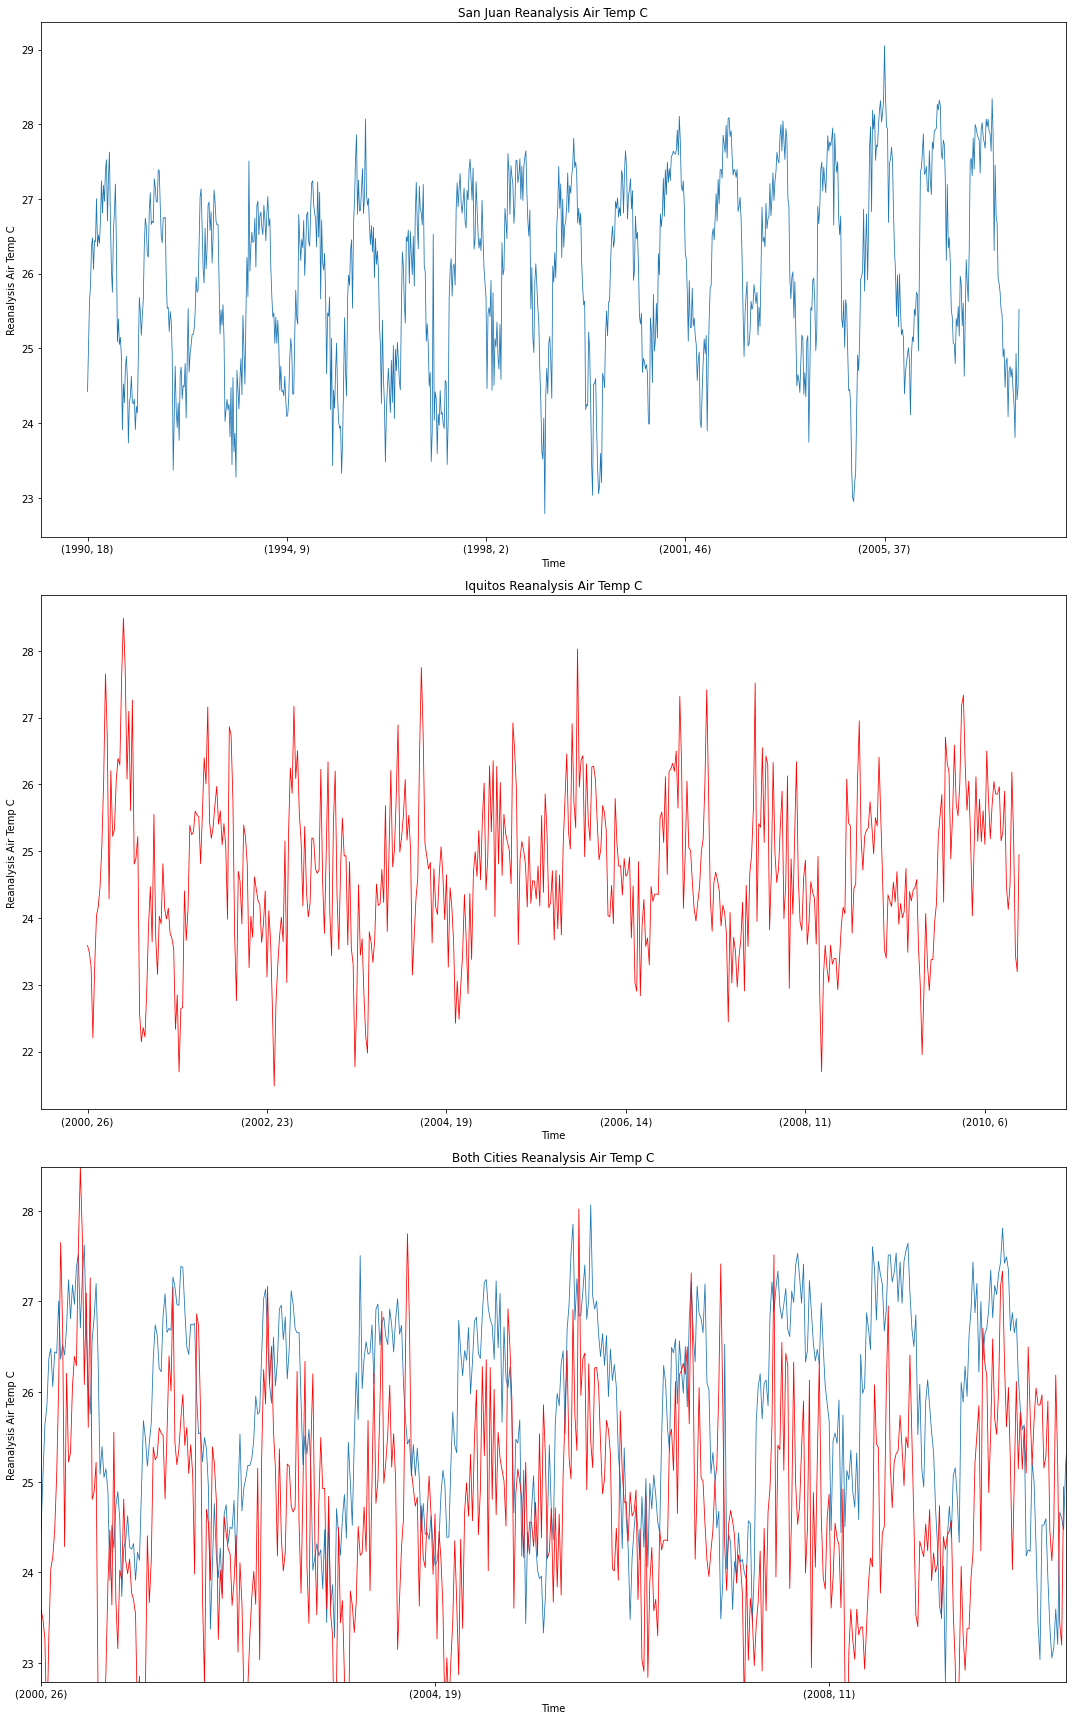

In [46]:
fig, axs = plt.subplots(3, 1, figsize=(15, 24))

#San Juan Reanalysis Air Temp C
sj_training_data_imputed.reanalysis_air_temp_k.plot.line(lw=0.8, ax=axs[0])
axs[0].set_title('San Juan Reanalysis Air Temp C')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Reanalysis Air Temp C')

#Iquitos Reanalysis Air Temp C
iq_training_data_imputed.reanalysis_air_temp_k.plot.line(lw=0.8, color='r', ax=axs[1])
axs[1].set_title('Iquitos Reanalysis Air Temp C')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Reanalysis Air Temp C')

#Both Cities Reanalysis Air Temp C
sj_training_data_imputed.reanalysis_air_temp_k.plot.line(lw=0.8, ax=axs[2])
iq_training_data_imputed.reanalysis_air_temp_k.plot.line(lw=0.8, color='r', ax=axs[2])
axs[2].set_xlim([0, 520])
axs[2].set_ylim([sj_training_data_imputed.reanalysis_air_temp_k.min(), iq_training_data_imputed.reanalysis_air_temp_k.max()])
axs[2].set_title('Both Cities Reanalysis Air Temp C')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Reanalysis Air Temp C')

plt.tight_layout()
plt.show()

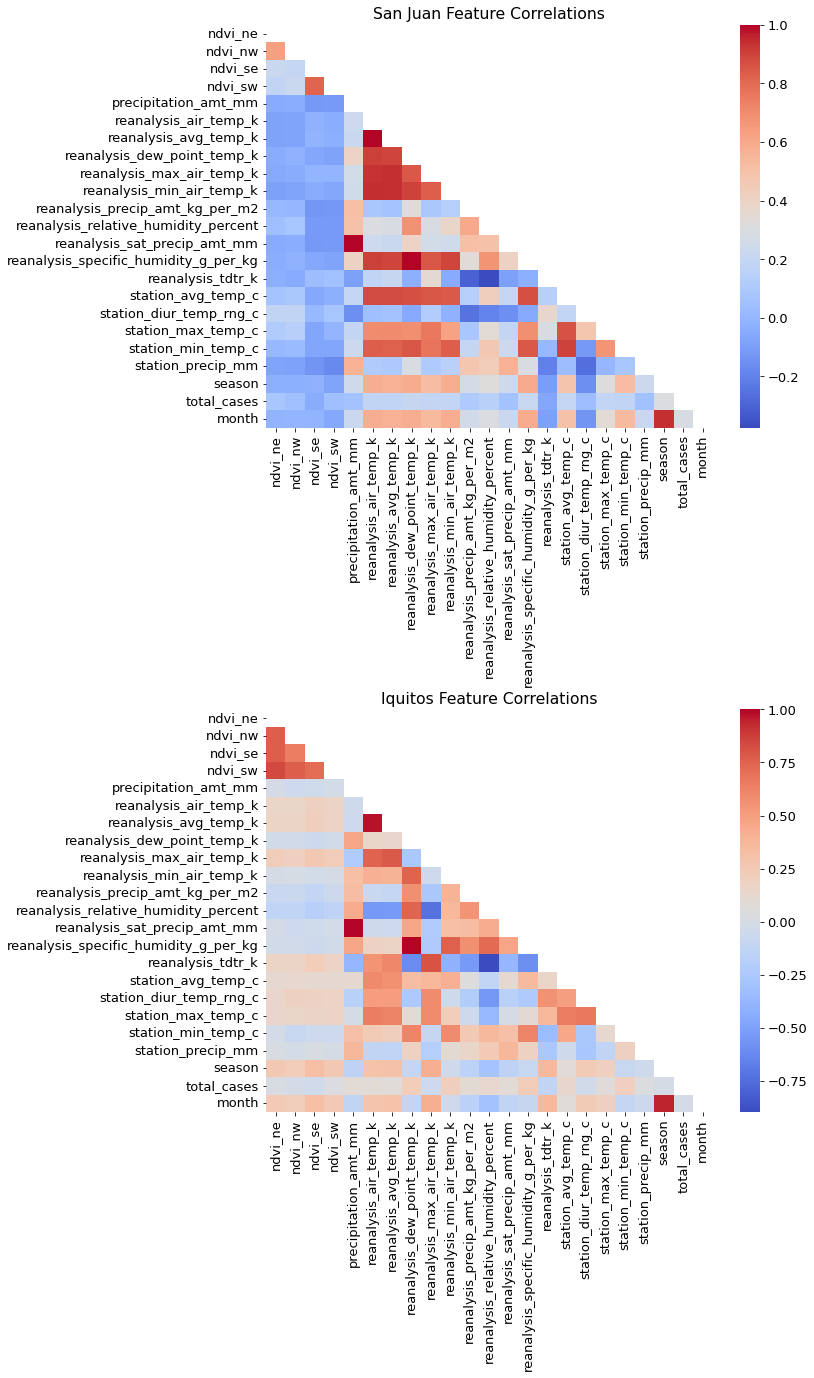

In [69]:
#Analyzing feature correlations per city
sj_corr = sj_training_data_imputed.corr()
iq_corr = iq_training_data_imputed.corr()

#Create upper-triangular masks
mask_sj = np.triu(np.ones_like(sj_corr, dtype=bool))
mask_iq = np.triu(np.ones_like(iq_corr, dtype=bool))

f, ax = plt.subplots(2, 1, figsize=(10, 20))

sns.heatmap(sj_corr, mask=mask_sj, ax=ax[0], annot=False, cmap='coolwarm')
ax[0].set_title('San Juan Feature Correlations')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

sns.heatmap(iq_corr, mask=mask_iq, ax=ax[1], annot=False, cmap='coolwarm')
ax[1].set_title('Iquitos Feature Correlations')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

plt.subplots_adjust(hspace=0.7)
plt.show()

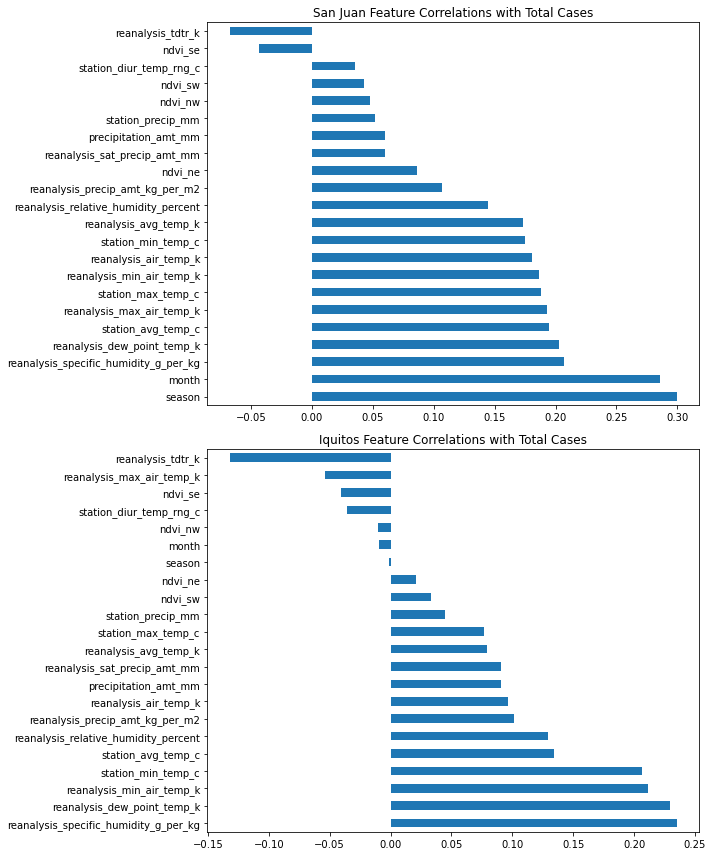

In [49]:
#Analyzing feature correlations with target (total_cases)
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

#San Juan
(sj_corr.total_cases
    .drop('total_cases')  #don't compare with myself
    .sort_values(ascending=False)
    .plot.barh(ax=ax[0]))
ax[0].set_title('San Juan Feature Correlations with Total Cases')

#Iquitos
(iq_corr.total_cases
    .drop('total_cases')  #don't compare with myself
    .sort_values(ascending=False)
    .plot.barh(ax=ax[1]))
ax[1].set_title('Iquitos Feature Correlations with Total Cases')

plt.tight_layout()
plt.show()

In [50]:
#Reloading data for column indexes
train_features = pd.read_csv("dengue_features_train.csv")
train_labels = pd.read_csv("dengue_labels_train.csv")

train_labels.index = pd.DatetimeIndex(train_features.week_start_date)

iq_total_cases = train_labels.total_cases[train_labels.city == 'iq']
sj_total_cases = train_labels.total_cases[train_labels.city == 'sj']

iq_weekly_total_cases = iq_total_cases.resample('W').sum()
iq_monthly_total_cases = iq_total_cases.resample('M').sum()
iq_yearly_total_cases = iq_total_cases.resample("Y").sum()

sj_weekly_total_cases = sj_total_cases.resample('W').sum()
sj_monthly_total_cases = sj_total_cases.resample('M').sum()
sj_yearly_total_cases = sj_total_cases.resample("Y").sum()

Text(0, 0.5, 'Corr Strength')

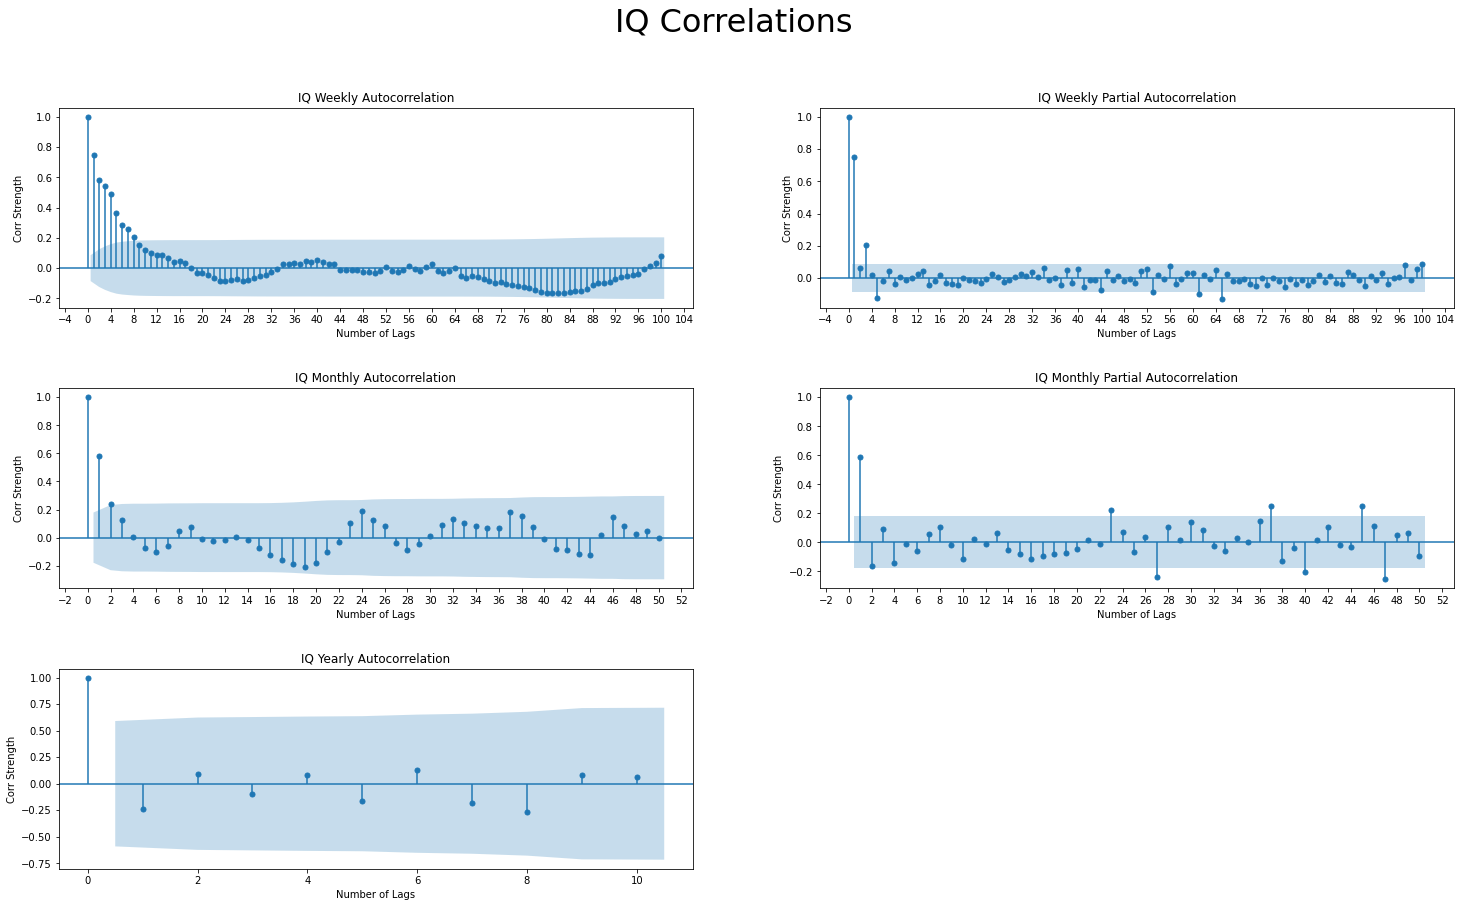

In [51]:
#Examining autocorrelations for Iquitos
fig = plt.figure(figsize=(25,14))
fig.suptitle('IQ Correlations', size = 32)
fig.subplots_adjust(hspace=.4)

#WEEKLY
ax3 = fig.add_subplot(321)
ax3.xaxis.set_major_locator(plt.MultipleLocator(4))
fig = sm.graphics.tsa.plot_acf(iq_weekly_total_cases, lags = 100, ax=ax3)
plt.title("IQ Weekly Autocorrelation")
plt.xlabel("Number of Lags")
plt.ylabel("Corr Strength")

ax4 = fig.add_subplot(322)
ax4.xaxis.set_major_locator(plt.MultipleLocator(4))
fig = sm.graphics.tsa.plot_pacf(iq_weekly_total_cases, lags = 100, ax=ax4)
plt.title("IQ Weekly Partial Autocorrelation")
plt.xlabel("Number of Lags")
plt.ylabel("Corr Strength")


#MONTHLY
ax1 = fig.add_subplot(323)
ax1.xaxis.set_major_locator(plt.MultipleLocator(2))
fig = sm.graphics.tsa.plot_acf(iq_monthly_total_cases, lags = 50, ax=ax1)
plt.title("IQ Monthly Autocorrelation")
plt.xlabel("Number of Lags")
plt.ylabel("Corr Strength")

ax2 = fig.add_subplot(324)
ax2.xaxis.set_major_locator(plt.MultipleLocator(2))
fig = sm.graphics.tsa.plot_pacf(iq_monthly_total_cases, lags = 50, ax=ax2)
plt.title("IQ Monthly Partial Autocorrelation")
plt.xlabel("Number of Lags")
plt.ylabel("Corr Strength")


#YEARLY
ax5 = fig.add_subplot(325)
fig = sm.graphics.tsa.plot_acf(iq_yearly_total_cases, lags = 10, ax=ax5)
plt.title("IQ Yearly Autocorrelation")
plt.xlabel("Number of Lags")
plt.ylabel("Corr Strength")

Text(0, 0.5, 'Corr Strength')

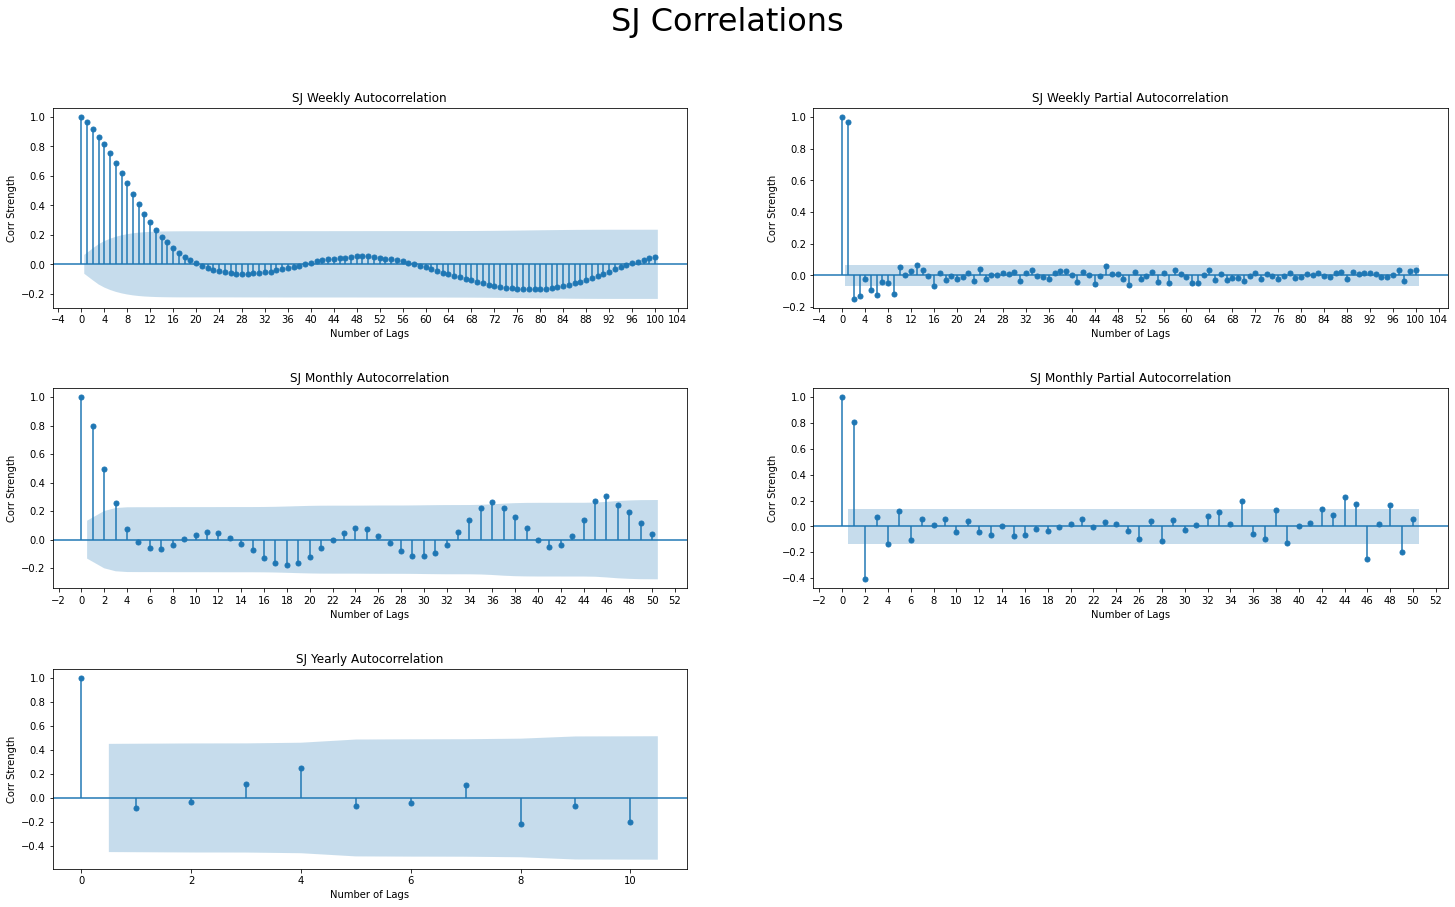

In [52]:
#Examining autocorrelations for San Juan
fig = plt.figure(figsize=(25,14))
fig.suptitle('SJ Correlations', size = 32)
fig.subplots_adjust(hspace=.4)

#WEEKLY
ax3 = fig.add_subplot(321)
ax3.xaxis.set_major_locator(plt.MultipleLocator(4))
fig = sm.graphics.tsa.plot_acf(sj_weekly_total_cases, lags = 100, ax=ax3)
plt.title("SJ Weekly Autocorrelation")
plt.xlabel("Number of Lags")
plt.ylabel("Corr Strength")

ax4 = fig.add_subplot(322)
ax4.xaxis.set_major_locator(plt.MultipleLocator(4))
fig = sm.graphics.tsa.plot_pacf(sj_weekly_total_cases, lags = 100, ax=ax4)
plt.title("SJ Weekly Partial Autocorrelation")
plt.xlabel("Number of Lags")
plt.ylabel("Corr Strength")


#MONTHLY
ax1 = fig.add_subplot(323)
ax1.xaxis.set_major_locator(plt.MultipleLocator(2))
fig = sm.graphics.tsa.plot_acf(sj_monthly_total_cases, lags = 50, ax=ax1)
plt.title("SJ Monthly Autocorrelation")
plt.xlabel("Number of Lags")
plt.ylabel("Corr Strength")

ax2 = fig.add_subplot(324)
ax2.xaxis.set_major_locator(plt.MultipleLocator(2))
fig = sm.graphics.tsa.plot_pacf(sj_monthly_total_cases, lags = 50, ax=ax2)
plt.title("SJ Monthly Partial Autocorrelation")
plt.xlabel("Number of Lags")
plt.ylabel("Corr Strength")

#YEARLY
ax5 = fig.add_subplot(325)
fig = sm.graphics.tsa.plot_acf(sj_yearly_total_cases, lags = 10, ax=ax5)
plt.title("SJ Yearly Autocorrelation")
plt.xlabel("Number of Lags")
plt.ylabel("Corr Strength")



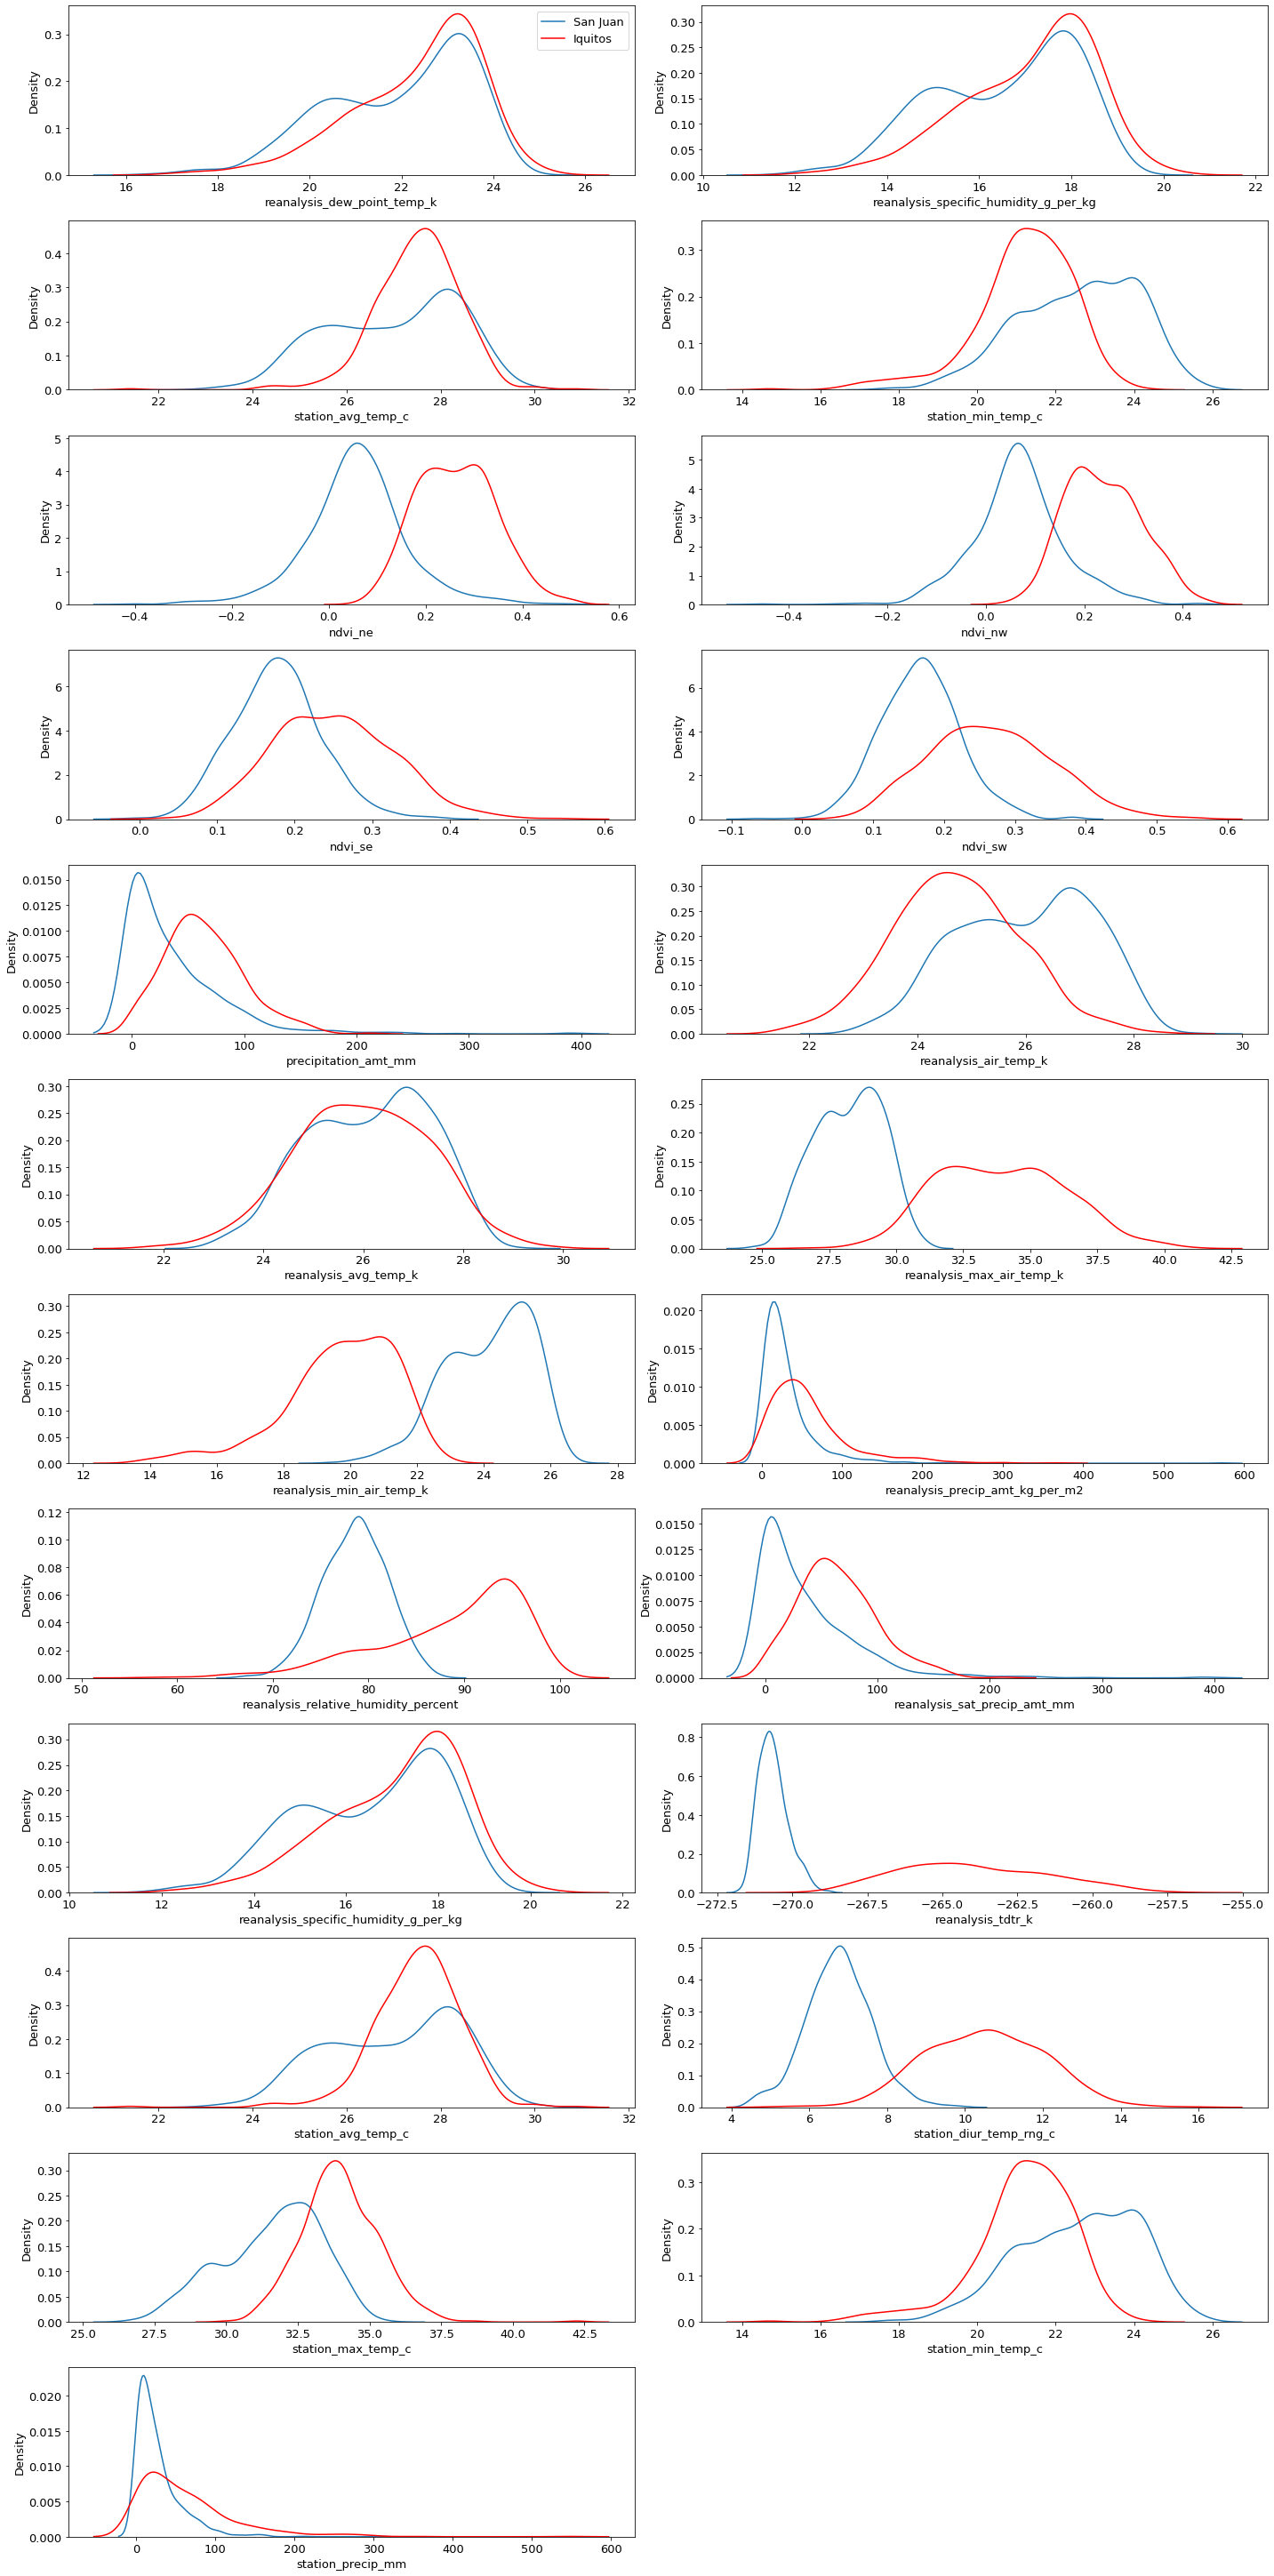

In [53]:
#Plotting KDEs for features in San Juan and Iquitos
plt.rc("font", size=13)
plt.figure(figsize=(20, 50))
alpha = 1
grid_size = (15, 2)

variables = [
    "reanalysis_dew_point_temp_k",
    "reanalysis_specific_humidity_g_per_kg",
    "station_avg_temp_c",
    "station_min_temp_c",
    "ndvi_ne",
    "ndvi_nw",
    "ndvi_se",
    "ndvi_sw",
    "precipitation_amt_mm",
    "reanalysis_air_temp_k",
    "reanalysis_avg_temp_k",
    "reanalysis_max_air_temp_k",
    "reanalysis_min_air_temp_k",
    "reanalysis_precip_amt_kg_per_m2",
    "reanalysis_relative_humidity_percent",
    "reanalysis_sat_precip_amt_mm",
    "reanalysis_specific_humidity_g_per_kg",
    "reanalysis_tdtr_k",
    "station_avg_temp_c",
    "station_diur_temp_rng_c",
    "station_max_temp_c",
    "station_min_temp_c",
    "station_precip_mm"
]

for i, var in enumerate(variables):
    #2 elements per row, so need i//2
    #mod2 for 0 1 column
    ax = plt.subplot2grid(grid_size, (i // 2, i % 2))
    sns.kdeplot(sj_training_data_imputed[var], ax=ax, alpha=alpha, label='San Juan')
    sns.kdeplot(iq_training_data_imputed[var], ax=ax, alpha=alpha, color='r', label='Iquitos')
    
    if i == 0:  #Add legend only on the first plot
        ax.legend()
plt.tight_layout()
plt.show()

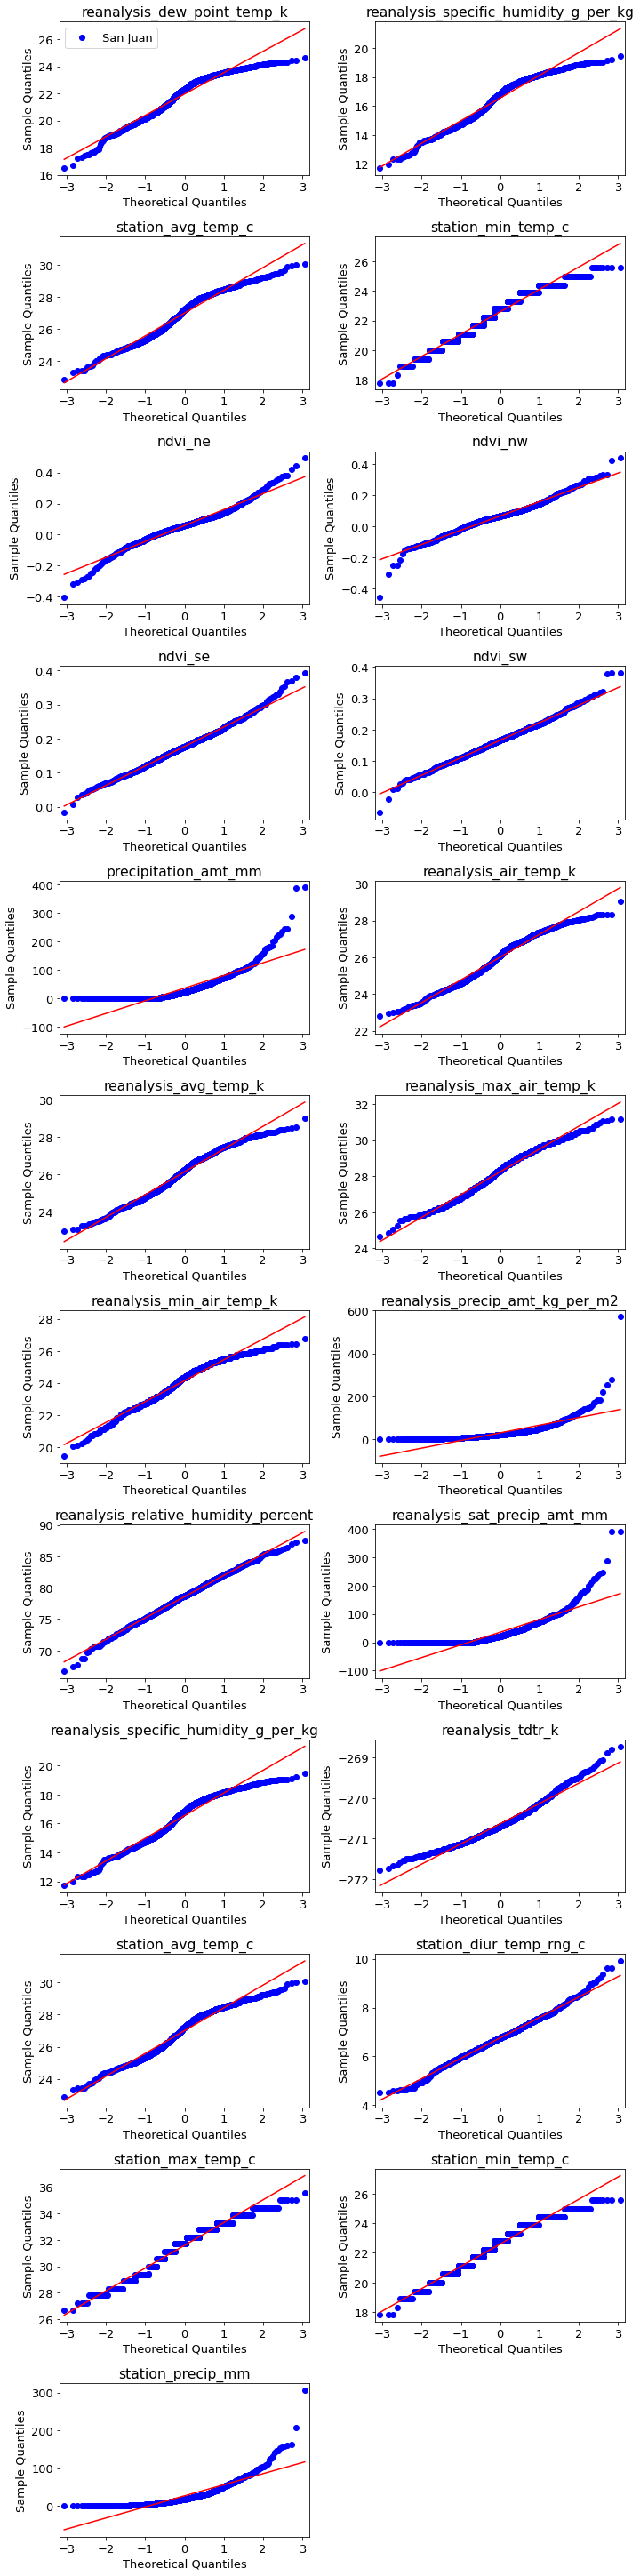

In [55]:
#QQ Plots of San Juan training data
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels.graphics.gofplots")

plt.rc("font", size=13)
plt.figure(figsize=(10, 50))
alpha = 1
grid_size = (15, 2)

for i, var in enumerate(variables):
    ax = plt.subplot2grid(grid_size, (i // 2 , i % 2))
    sm.qqplot(sj_training_data_imputed[var].dropna(), line='s', ax=ax, alpha=alpha, label='San Juan')
    ax.set_title(var)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

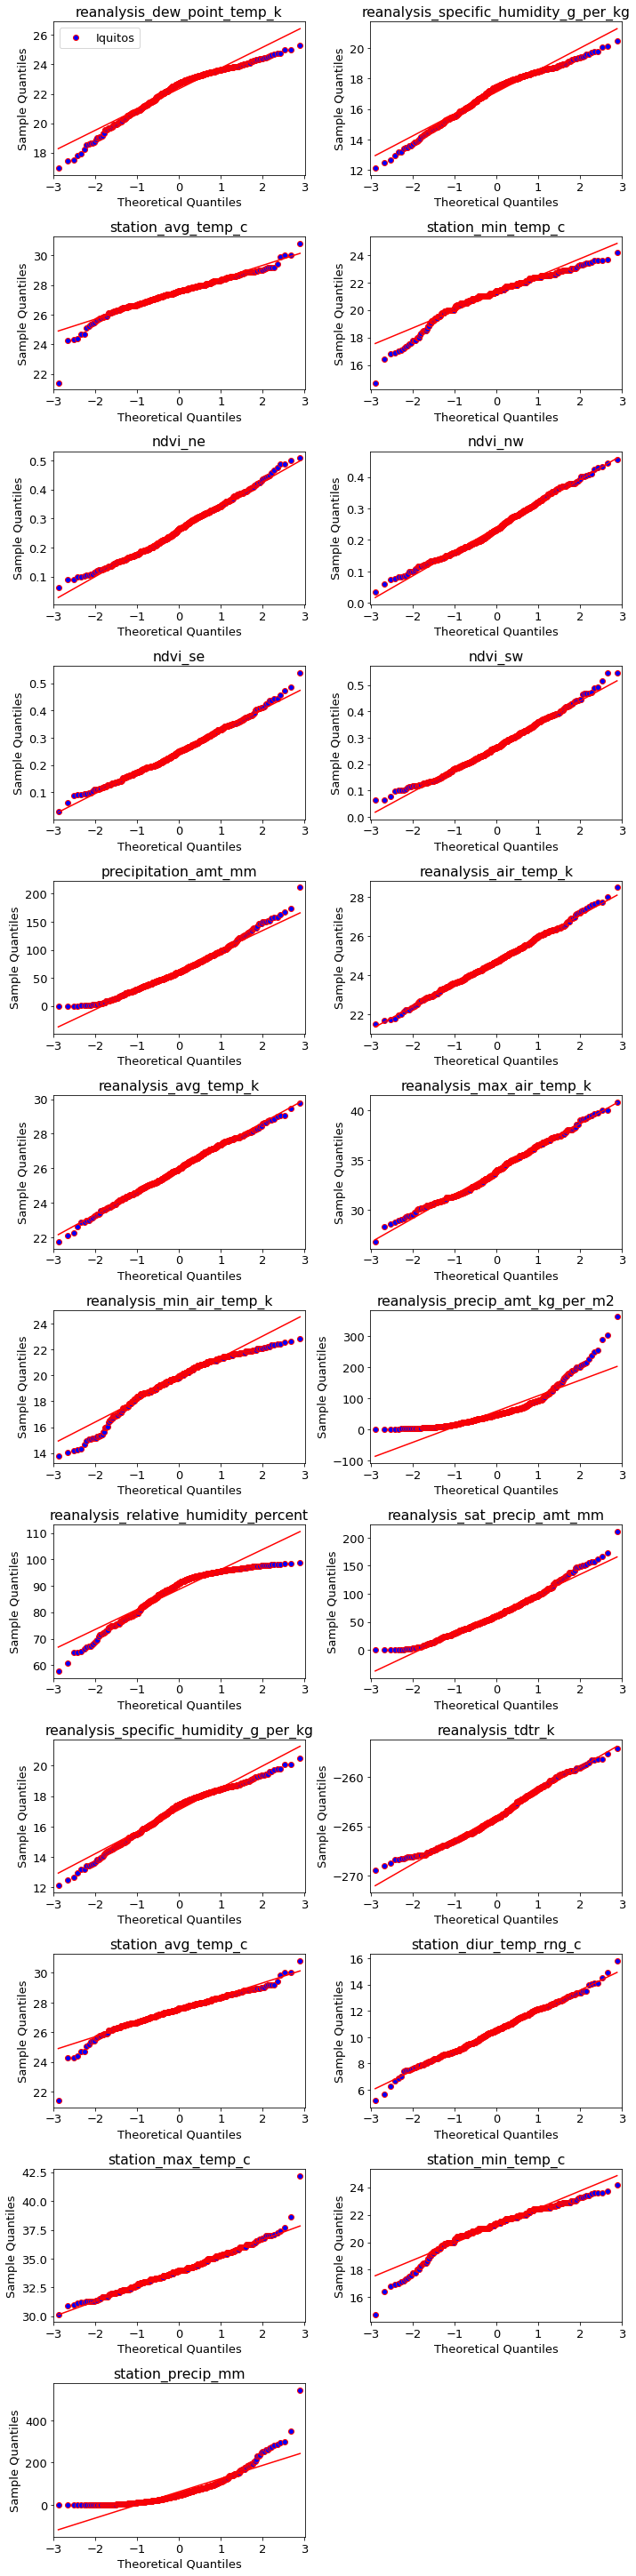

In [56]:
#QQ Plots of Iquitos training data
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels.graphics.gofplots")

plt.rc("font", size=13)
plt.figure(figsize=(10, 50))
alpha = 1
grid_size = (15, 2)

for i, var in enumerate(variables):
    ax = plt.subplot2grid(grid_size, (i // 2 , i % 2))
    sm.qqplot(iq_training_data_imputed[var].dropna(), line='s', ax=ax, alpha=alpha, label='Iquitos', color='r')
    ax.set_title(var)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

No handles with labels found to put in legend.


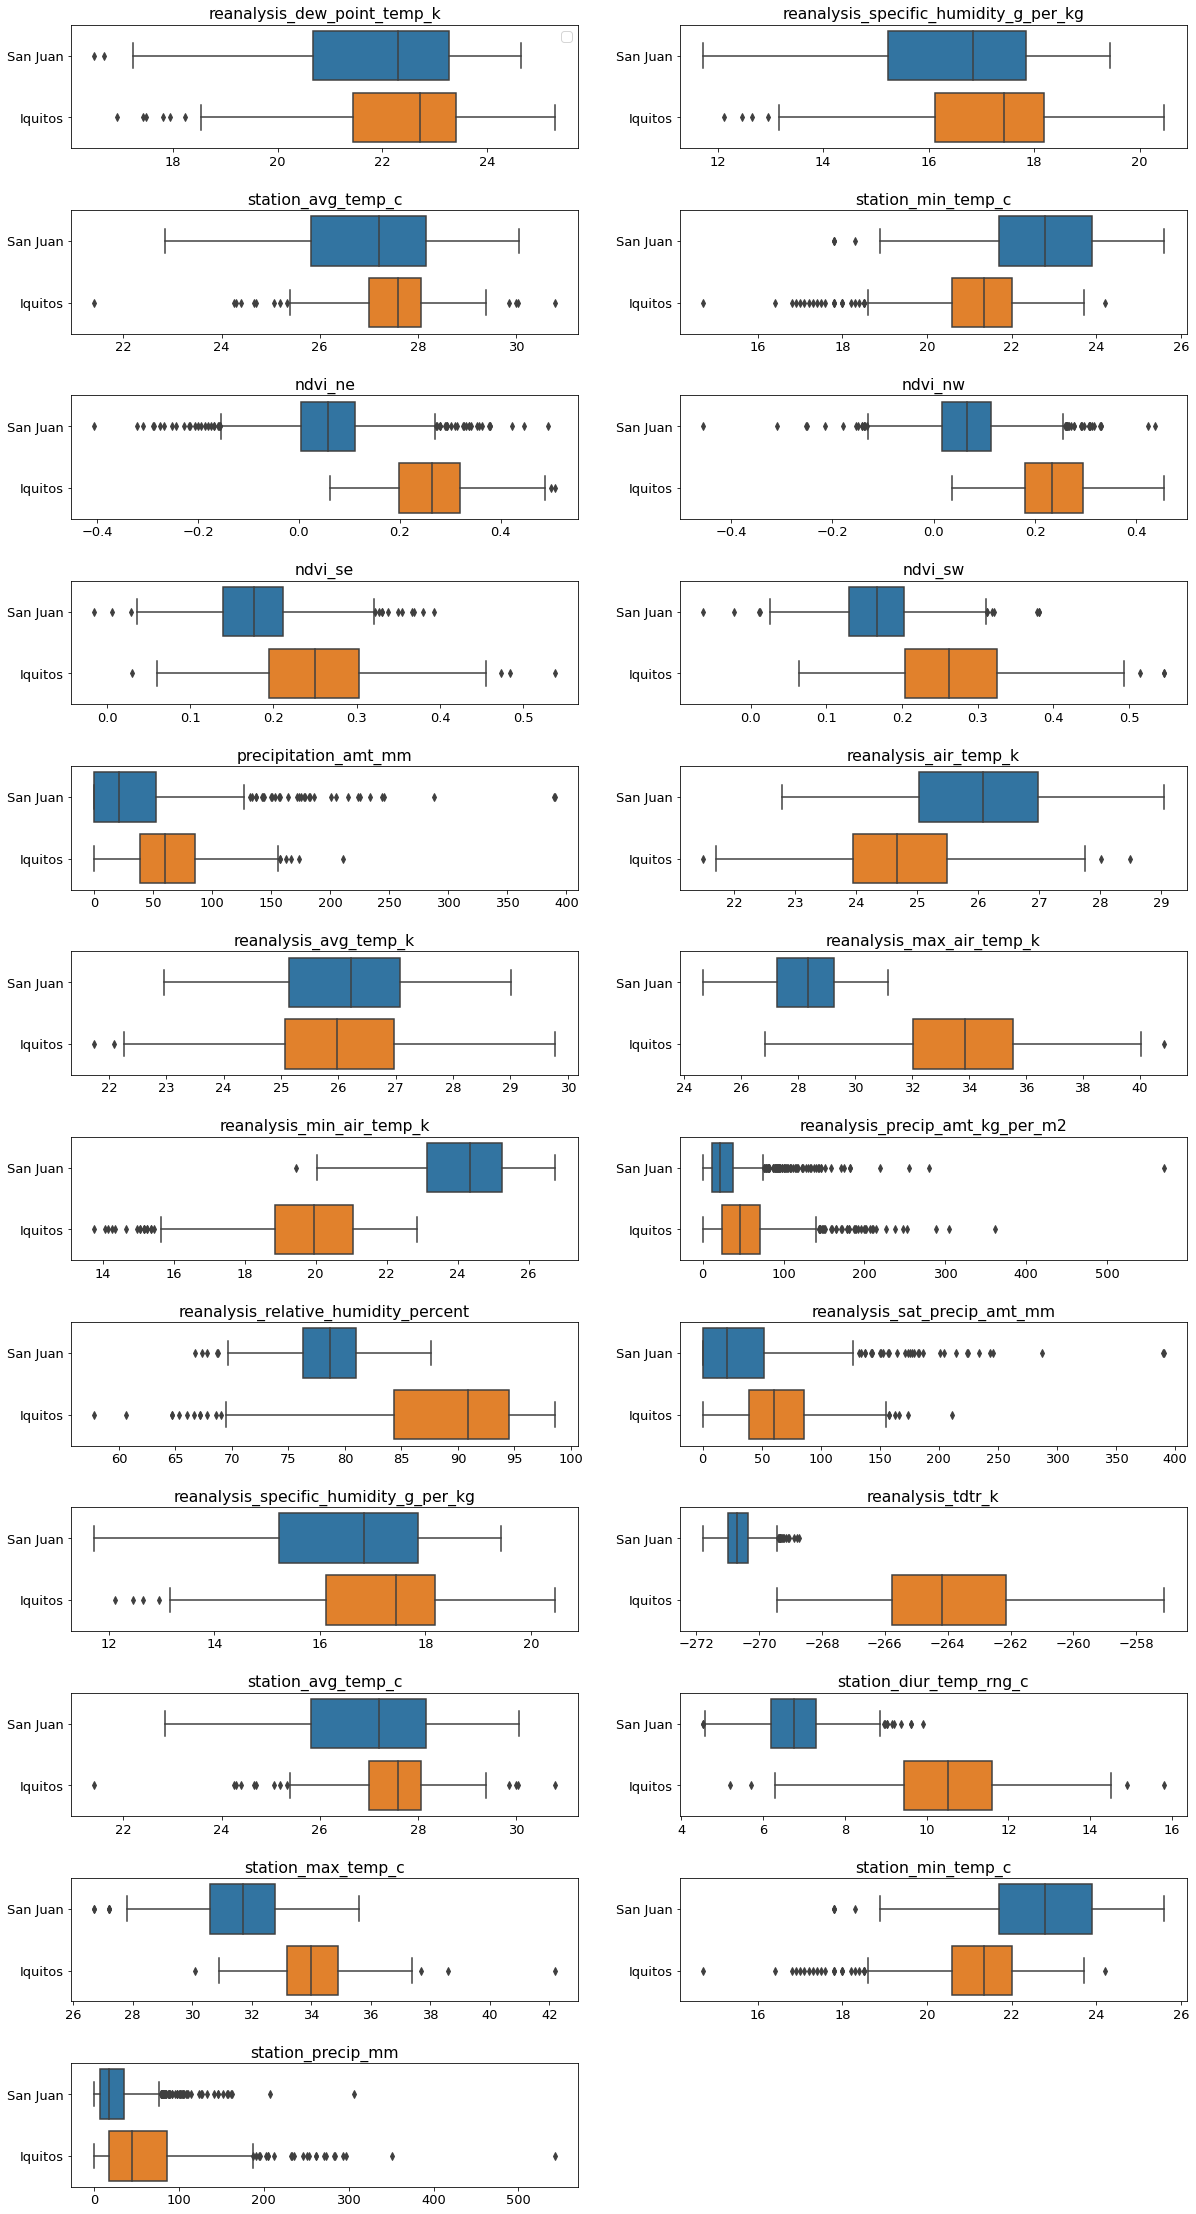

In [57]:
plt.rc("font", size=13)
plt.figure(figsize=(20, 50))  # Adjust the figure size if needed
grid_size = (15, 2)  # Adjust the grid size if needed

for i, var in enumerate(variables):
    ax = plt.subplot2grid(grid_size, (i//2, i%2))
    sns.boxplot(data=[sj_training_data_imputed[var], iq_training_data_imputed[var]], ax=ax, orient='h')
    ax.set_title(var)
    ax.yaxis.set_major_locator(ticker.FixedLocator([0, 1]))
    ax.set_yticklabels(['San Juan', 'Iquitos'])
    if i == 0:  #Add legend only on the first plot
        ax.legend()

plt.subplots_adjust(hspace=0.5)

plt.show()

In [58]:
sj_ndvi_ne_column_data = sj_testing_data['ndvi_ne'].dropna()

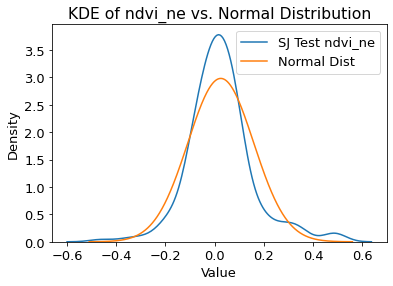

<Figure size 720x864 with 0 Axes>

In [59]:
#Checking distribution of ndvi_ne for best imputation strategy
sns.kdeplot(sj_ndvi_ne_column_data, label='SJ Test ndvi_ne')
mean, std = sj_ndvi_ne_column_data.mean(), sj_ndvi_ne_column_data.std()

x = np.linspace(mean - 4*std, mean + 4*std, 1000)
plt.plot(x, norm.pdf(x, mean, std), label='Normal Dist')

plt.title('KDE of ndvi_ne vs. Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.figure(figsize=(10,12))
plt.show()

In [ ]:
#Final steps for preprocessing

#Remove week_start_date from training data
sj_training_data_imputed = sj_training_data_imputed.drop('total_cases', axis=1)
iq_training_data_imputed = iq_training_data_imputed.drop('total_cases', axis=1)

#Prep labels for train test splitting
sj_train_labels = sj_train_labels[['total_cases']].reset_index(drop=True)
iq_train_labels = iq_train_labels[['total_cases']].reset_index(drop=True)

#Remove week_start_date from test data
sj_testing_data = sj_testing_data.drop('week_start_date', axis=1)
iq_testing_data = iq_testing_data.drop('week_start_date', axis=1)

#Export preprocessing training and testing data, separated by city
sj_training_data_imputed.to_csv('sj_training_data_imputed.csv', index=False)
iq_training_data_imputed.to_csv('iq_training_data_imputed.csv', index=False)

sj_train_labels = sj_train_labels.to_csv('sj_train_labels.csv', index=False)
iq_train_labels = iq_train_labels.to_csv('iq_train_labels.csv', index=False)

sj_testing_data.to_csv('sj_testing_data.csv', index=False)
iq_testing_data.to_csv('iq_testing_data.csv', index=False)